In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
# import tensorflow_probability as tfp
import tensorflow as tf
from uitils import *
# from uitils import bin_ploter
import pandas as pd
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, auc, recall_score, f1_score, confusion_matrix


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import lightgbm as lgb
print('GPU support:', lgb.LGBMClassifier(device='gpu').get_params()['device'])



Num GPUs Available:  1
GPU support: gpu


# Data Loading

In [4]:
creditcard_path =get_full_path('../datasets/creditcard.csv')
# fraudulent=1 
# unlabeled=0
creditcard_df = pd.read_csv(creditcard_path)
# x_train = creditcard_df.drop('Class', axis=1) 
# y_train = creditcard_df['Class']

# Separate the positive and negative instances
positives = creditcard_df[creditcard_df['Class'] == 1]
negatives = creditcard_df[creditcard_df['Class'] == 0]

# Randomly sample 10,000 negative examples
neg_sample = negatives.sample(n=600, random_state=42)

# Concatenate the positive examples with the sampled negative examples
sampled_df = pd.concat([positives, neg_sample])

# Shuffle the dataset to mix up the rows
sampled_df = sampled_df.sample(frac=1, random_state=42)

# Split the features and labels
x_train_sampled = sampled_df.drop('Class', axis=1)
y_train_sampled = sampled_df['Class']

# Split into training and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_train_sampled, y_train_sampled, test_size=0.1, random_state=42)

positives_test = positives.sample(frac=1, random_state=42)
negatives_test = negatives.sample(n=len(positives_test), random_state=42)

# Combine positive and negative examples to form the test set
test_df = pd.concat([positives_test, negatives_test])

# Shuffle the test dataset to mix up the rows
test_df = test_df.sample(frac=1, random_state=42)

# Split the features and labels for the test set
x_test = test_df.drop('Class', axis=1)
y_test = test_df['Class']
# x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
# x_train=x_train[:1000]
# print("Training labels distribution:", np.bincount(y_train))
print("Training labels distribution:", np.bincount(y_train))
print("Training labels distribution:", np.bincount(y_test))

Training labels distribution: [540 442]
Training labels distribution: [492 492]


In [6]:
y_test

255545    0
77099     1
76163     0
152223    1
42887     1
         ..
190368    1
150644    1
271842    0
64329     1
229712    1
Name: Class, Length: 984, dtype: int64

# Pre-training

In [5]:
import lightgbm as lgb

train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_test, label=y_test)
params = {
    'boosting_type': 'gbdt',  # Gradient boosting decision tree
    'objective': 'binary',    # Binary classification
    'metric': 'binary_logloss',  # Evaluation metric
    'num_leaves': 31,         # Number of leaves in full tree
    'learning_rate': 0.01,    # Learning rate
    'feature_fraction': 0.9,  # Fraction of features to be used at each iteration
    'bagging_fraction': 0.8,  # Fraction of data to be used for each iteration
    'bagging_freq': 5, 
    'device': 'gpu',       # Frequency for bagging
    'verbose': 1              # Verbose output
}

num_initial_round = 15
model_lgb = lgb.train(params, train_data, num_boost_round=num_initial_round, valid_sets=[test_data])
model_lgb.save_model('lgb_model_test.weights.h5')


y_pred_prob = model_lgb.predict(x_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.010726 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450102 -> initscore=-0.200259
[LightGBM] [Info] Start training from score -0.200259
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.006117 secs. 0 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

### Probablistic outcome of classifer to pre-train policy network
 

Classifer predicted labels distribution: [379 603]


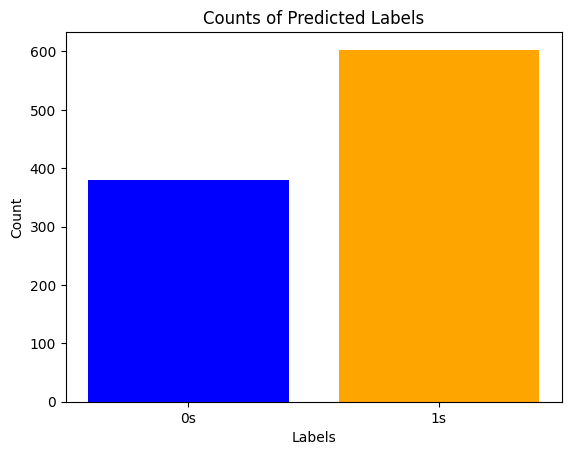

In [6]:
y_pred = model_lgb.predict(x_train, num_iteration=model_lgb.best_iteration)
threshold = min(y_pred[y_train == 1])
lgb_predicted_labels = np.array([1 if pred >= threshold else 0 for pred in y_pred])
print("Classifer predicted labels distribution:", np.bincount(lgb_predicted_labels))

bin_ploter(predicted_labels=lgb_predicted_labels)

In [15]:
# Policy-Network Model

class PolicyGradientNetwork:
    def __init__(self):
        self.model = self._create_model()
    
    def _create_model(self):
        model = Sequential([
            Dense(64, input_shape=(input_dimension,)),  # Adjust `input_dimension` to match your feature count
            Activation('relu'),
            Dense(128),
            Activation('relu'),
            Dense(64),
            Activation('relu'),
            Dense(32),
            Activation('relu'),
            Dense(16),
            Activation('relu'),
            Dense(1),  # Output layer for binary classification
            Activation('sigmoid')
        ])
        return model
    
    def get_model(self):
        return self.model
    
input_dimension = x_train.shape[1]
policy_network = PolicyGradientNetwork()
pn_model = policy_network.get_model()

pn_model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model with one-hot encoded labels
history_2 = pn_model.fit(x_train.to_numpy(), lgb_predicted_labels, epochs=15, batch_size=5, validation_split=0.2)
pn_model.save_weights('pn_mlp_model_.weights.h5')
# pn_model.load_weights('pn_mlp_model_.weights.h5')

Epoch 1/60
157/157 [==============================] - 4s 25ms/step - loss: 340.9953 - accuracy: 0.5478 - val_loss: 0.7070 - val_accuracy: 0.3807
Epoch 2/60
157/157 [==============================] - 4s 25ms/step - loss: 0.6820 - accuracy: 0.5732 - val_loss: 0.6609 - val_accuracy: 0.6244
Epoch 3/60
157/157 [==============================] - 4s 24ms/step - loss: 0.6686 - accuracy: 0.6115 - val_loss: 0.6595 - val_accuracy: 0.6244
Epoch 4/60
157/157 [==============================] - 4s 24ms/step - loss: 0.6682 - accuracy: 0.6115 - val_loss: 0.6599 - val_accuracy: 0.6244
Epoch 5/60
157/157 [==============================] - 4s 24ms/step - loss: 0.6690 - accuracy: 0.6115 - val_loss: 0.6597 - val_accuracy: 0.6244
Epoch 6/60
157/157 [==============================] - 4s 25ms/step - loss: 0.6683 - accuracy: 0.6115 - val_loss: 0.6595 - val_accuracy: 0.6244
Epoch 7/60
157/157 [==============================] - 4s 25ms/step - loss: 0.6678 - accuracy: 0.6115 - val_loss: 0.6607 - val_accuracy: 0.62

31/31 [==============================] - 0s 6ms/step
Classifer predicted labels distribution: [  0 982]


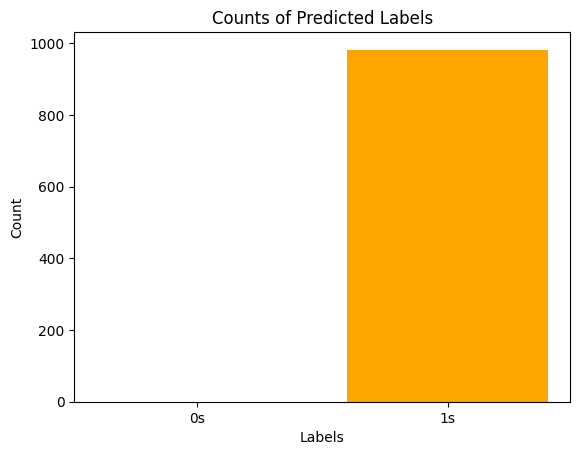

In [16]:
probabilities = pn_model.predict(x_train.to_numpy())
threshold = min(probabilities[y_train == 1])

# Convert probabilities to binary labels based on the threshold
predicted_labels = (probabilities >= threshold).astype(int)
np_predicted_labels = predicted_labels.flatten().astype(int)

print("Classifer predicted labels distribution:", np.bincount(np_predicted_labels))
bin_ploter(predicted_labels=np_predicted_labels)

## Interactive learning

In [17]:
import tensorflow as tf
import numpy as np

class Agent:
    def __init__(self, model, target_model, alpha=0.00001, gamma=0.99):
        self.gamma = gamma  # Discount factor
        self.lr = alpha  # Learning rate
        self.model = model  # Policy model
        self.target_model = target_model # target policy model
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []

    
    def choose_action(self, states, s, threshold=0.5):
        # Convert states to float32 tensor within the function
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        probabilities = self.target_model(states) 
        
        inferred_labels = tf.cast(probabilities > threshold, tf.int32)       
        s = tf.reshape(s, tf.shape(inferred_labels))  # Ensuring s is the same shape as inferred_labels
        actions = tf.where(s == 1, 1, inferred_labels)
        actions = tf.squeeze(actions)  # This should correctly squeeze actions to shape (128,)
        return actions.numpy(), probabilities.numpy()


        # actions = tf.cast(tf.random.uniform(tf.shape(probabilities)) < probabilities, tf.int32)
        # return actions.numpy(), probabilities.numpy()


    def store_transition(self, states, actions, rewards):
        self.state_memory.extend(states)
        self.action_memory.extend(actions)
        self.reward_memory.extend(rewards)

    def learn(self):
        actions = np.array(self.action_memory)
        rewards = np.array(self.reward_memory)
        states = np.array(self.state_memory)

        # Calculate discounted rewards
        G = np.zeros_like(rewards)
        for t in range(len(rewards)):
            G_sum = 0
            discount = 1
            for k in range(t, len(rewards)):
                G_sum += rewards[k] * discount
                discount *= self.gamma
            G[t] = G_sum

        # Updating policy
        with tf.GradientTape() as tape:
            loss = 0
            for idx, (g, state) in enumerate(zip(G, states)):
                state = tf.convert_to_tensor([state], dtype=tf.float32)
                probs = self.model(state, training=True)
                action_probs = tf.where(actions[idx] == 1, probs, 1 - probs)
                log_prob = tf.math.log(action_probs)
                loss += -g * tf.reduce_sum(log_prob)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        # Clear memory
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []


In [18]:
# Clone policy model for stable target policy
target_policy_model = tf.keras.models.clone_model(pn_model)
target_policy_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])


In [19]:
history = {
    'epoch_loss': [],
    'epoch_accuracy': [],
    'batch_loss': [],
    'batch_accuracy': [],
    'predictions': [],
    'rewards': [],
    'thresholds': [],
    'ROC_AUC': [],
    'accuracy':[],
    'PR_AUC':[],
    'recall':[],
    'f1':[]
}

agent = Agent(pn_model,target_model=target_policy_model, alpha=0.00001, gamma=0.99)
# Example parameters
n_epochs = 300
n_epochs = 10
batch_size = 128 # You can adjust the batch size as needed

def shuffle_data(x_train, y_train, s):
    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    return x_train[indices], y_train[indices], s[indices]

def create_mini_batches(x_train, y_train, s, batch_size):
    for start_idx in range(0, len(x_train) - batch_size + 1, batch_size):
        excerpt = slice(start_idx, start_idx + batch_size)
        yield x_train[excerpt], y_train[excerpt], s[excerpt]

def calculate_threshold(clf_probabilities, y_batch):
    # Identify indices of positive examples
    positive_indices = (y_batch == 1)
    
    # Calculate threshmin from positive examples
    if np.any(positive_indices):
        threshmin = np.min(clf_probabilities[positive_indices])
    else:
        threshmin = 0  # Default value if no positive examples are present

    # Identify U0 - samples with predictions >= threshmin
    U0_indices = (clf_probabilities >= threshmin)
    
    # Calculate the final threshold using Equation 5
    if np.any(U0_indices):
        threshold = np.mean(clf_probabilities[U0_indices])
    else:
        threshold = threshmin  # Use threshmin if no samples meet the U0 criteria

    return threshold

def calculate_rewards(clf_probabilities, y_batch, threshold):
    # Reward calculation needs to consider whether predictions meet a certain threshold
    # Positive examples above threshold or negative examples below threshold get positive rewards
    rewards = []
    for prob, actual in zip(clf_probabilities.flatten(), y_batch):
        if actual == 1 or (actual == 0 and prob >= threshold):
            reward = prob  # Reward is the probability itself if conditions are met
        else:
            reward = prob -1  # Otherwise, reward is the complement of the probability
        rewards.append(reward)
    return rewards

In [11]:
# num_initial_round = 5
# model_lgb = lgb.train(params, train_data, num_boost_round=num_initial_round, valid_sets=[test_data])
# model_lgb.save_model('lgb_model.we7ights.h5')


# y_pred = model_lgb.predict(x_train, num_iteration=model_lgb.best_iteration)
# threshold = min(y_pred[y_train == 1])
# lgb_predicted_labels = np.array([1 if pred >= threshold else 0 for pred in y_pred])
# print("Classifer predicted labels distribution:", np.bincount(lgb_predicted_labels))

In [20]:
def train_model(x_train, y_train, s, epochs=300, batch_size=128, model_lgb=model_lgb):
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    s = s.astype('float32')

    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, s))
    dataset = dataset.shuffle(buffer_size=len(x_train)).batch(len(y_train))
    # dataset = dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        # lgb_probabilities=None
        threshold = 0.5
        for x_batch, y_batch, s_batch in dataset:
            # Get actions and probabilities for the entire batch
            actions, probabilities = agent.choose_action(x_batch, s_batch, threshold=threshold)
            train_data = lgb.Dataset(x_batch, label=actions)
            valid_data = lgb.Dataset(x_batch, label=actions)
            model_lgb = lgb.train(params, train_data, num_boost_round=1, init_model=model_lgb, keep_training_booster=True)
    

            # Fit the model on the current batch and update history
            # batch_history = model.fit(x_batch, actions, epochs=1, batch_size=len(x_batch), validation_split=0.2)
            # history['batch_loss'].append(batch_history.history['loss'][0])
            # history['batch_accuracy'].append(batch_history.history['accuracy'][0])

            lgb_probabilities = model_lgb.predict(x_batch, num_iteration=model_lgb.best_iteration)
            threshold = calculate_threshold(lgb_probabilities, y_batch)
            rewards = calculate_rewards(lgb_probabilities, y_batch, threshold)

            # Store transitions and learn from them
            agent.store_transition(x_batch.numpy(), actions, rewards)
            agent.learn()
            # break

        y_pred_prob = model_lgb.predict(x_test)
        threshold = calculate_threshold(y_pred_prob, y_test)
        print(f"threshold: {threshold}")
        y_pred = np.where(y_pred_prob >= threshold, 1, 0)

        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print("AUC-ROC:", roc_auc)
        history['ROC_AUC'].append(roc_auc)

        accuracy = accuracy_score(y_test, y_pred)
        print("Accuracy:", accuracy)
        history['accuracy'].append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_true=y_test, probas_pred=y_pred_prob)
        pr_auc = auc(recall, precision)
        history['PR_AUC'].append(pr_auc)
        print("Precision:", pr_auc)

        conf_matrix = confusion_matrix(y_test, y_pred)
        print("Confusion Matrix:")
        print(conf_matrix)
        # Test the confustion matrix and test the inputs

        recall = recall_score(y_test, y_pred)
        print("Recall:", recall)
        history['recall'].append(recall)

        # Calculate F1 score
        f1 = f1_score(y_test, y_pred)
        print("F1 Score:", f1)
        history['f1'].append(f1)


        if epoch % 3 == 0:
            print("Updating target policy...")
            agent.target_model.set_weights(agent.model.get_weights())


train_model(x_train=x_train, y_train=y_train, s=y_train, model_lgb=model_lgb)

Epoch 1/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.006108 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004387 secs. 0 sparse feature groups
threshold: 0.4661643684208331
AUC-ROC: 0.9895998578888228
Accuracy: 0.9390243902439024
Precision: 0.9910418189920904
Confusion Matrix:
[[483   9]
 [ 51 441]]
Recall: 0.8963414634146342
F1 Score: 0.9363057324840764
Updating target policy...
Epoch 2/300
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 982, number of negative: 0
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the tra

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005046 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004770 secs. 0 sparse feature groups
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
threshold: 0.4661643684208331
AUC-ROC: 0.9895998578888228
Accuracy: 0.9390243902439024
Precision: 0.9910418189920904
Confusion Matrix:
[[483   9]
 [ 51 441]]
Recall: 0.8963414634146342
F1 Score: 0.9363057324840764
Epoch 3/300
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 982, number of negative: 0
[LightGBM] [Info] This is the GPU trainer!!
[Light

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005410 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004607 secs. 0 sparse feature groups
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
threshold: 0.4661643684208331
AUC-ROC: 0.9895998578888228
Accuracy: 0.9390243902439024
Precision: 0.9910418189920904
Confusion Matrix:
[[483   9]
 [ 51 441]]
Recall: 0.8963414634146342
F1 Score: 0.9363057324840764
Epoch 4/300
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 982, number of negative: 0
[LightGBM] [Info] This is the GPU trainer!!
[Light

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004714 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004346 secs. 0 sparse feature groups
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
threshold: 0.4661643684208331
AUC-ROC: 0.9895998578888228
Accuracy: 0.9390243902439024
Precision: 0.9910418189920904
Confusion Matrix:
[[483   9]
 [ 51 441]]
Recall: 0.8963414634146342
F1 Score: 0.9363057324840764
Updating target policy...
Epoch 5/300
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 982, number of negative: 0
[LightGBM] [Info] This i

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004403 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004667 secs. 0 sparse feature groups
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
threshold: 0.4661643684208331
AUC-ROC: 0.9895998578888228
Accuracy: 0.9390243902439024
Precision: 0.9910418189920904
Confusion Matrix:
[[483   9]
 [ 51 441]]
Recall: 0.8963414634146342
F1 Score: 0.9363057324840764
Epoch 6/300
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 982, number of negative: 0
[LightGBM] [Info] This is the GPU trainer!!
[Light

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004809 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004518 secs. 0 sparse feature groups
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
threshold: 0.4661643684208331
AUC-ROC: 0.9895998578888228
Accuracy: 0.9390243902439024
Precision: 0.9910418189920904
Confusion Matrix:
[[483   9]
 [ 51 441]]
Recall: 0.8963414634146342
F1 Score: 0.9363057324840764
Epoch 7/300
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 982, number of negative: 0
[LightGBM] [Info] This is the GPU trainer!!
[Light

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005037 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004929 secs. 0 sparse feature groups
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
threshold: 0.4661643684208331
AUC-ROC: 0.9895998578888228
Accuracy: 0.9390243902439024
Precision: 0.9910418189920904
Confusion Matrix:
[[483   9]
 [ 51 441]]
Recall: 0.8963414634146342
F1 Score: 0.9363057324840764
Updating target policy...
Epoch 8/300
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 982, number of negative: 0
[LightGBM] [Info] This i

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004764 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004380 secs. 0 sparse feature groups
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
threshold: 0.4661643684208331
AUC-ROC: 0.9895998578888228
Accuracy: 0.9390243902439024
Precision: 0.9910418189920904
Confusion Matrix:
[[483   9]
 [ 51 441]]
Recall: 0.8963414634146342
F1 Score: 0.9363057324840764
Epoch 9/300
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 982, number of negative: 0
[LightGBM] [Info] This is the GPU trainer!!
[Light

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004635 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004474 secs. 0 sparse feature groups
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
threshold: 0.4661643684208331
AUC-ROC: 0.9895998578888228
Accuracy: 0.9390243902439024
Precision: 0.9910418189920904
Confusion Matrix:
[[483   9]
 [ 51 441]]
Recall: 0.8963414634146342
F1 Score: 0.9363057324840764
Epoch 10/300
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 982, number of negative: 0
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004960 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004656 secs. 0 sparse feature groups
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
threshold: 0.4661643684208331
AUC-ROC: 0.9895998578888228
Accuracy: 0.9390243902439024
Precision: 0.9910418189920904
Confusion Matrix:
[[483   9]
 [ 51 441]]
Recall: 0.8963414634146342
F1 Score: 0.9363057324840764
Updating target policy...
Epoch 11/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Tota

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004631 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004584 secs. 0 sparse feature groups
threshold: 0.46645851530091004
AUC-ROC: 0.989409825500694
Accuracy: 0.9390243902439024
Precision: 0.9909019930075846
Confusion Matrix:
[[483   9]
 [ 51 441]]
Recall: 0.8963414634146342
F1 Score: 0.9363057324840764
Epoch 12/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004827 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004717 secs. 0 sparse feature groups
threshold: 0.47561726792588926
AUC-ROC: 0.9897485788882279
Accuracy: 0.9420731707317073
Precision: 0.9910545908958817
Confusion Matrix:
[[488   4]
 [ 53 439]]
Recall: 0.8922764227642277
F1 Score: 0.9390374331550803
Epoch 13/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GP

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.061772 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.003988 secs. 0 sparse feature groups
threshold: 0.47678288494047855
AUC-ROC: 0.989727923193866
Accuracy: 0.9410569105691057
Precision: 0.9910564520399269
Confusion Matrix:
[[489   3]
 [ 55 437]]
Recall: 0.8882113821138211
F1 Score: 0.9377682403433476
Updating target policy...
Epoch 14/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.029201 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004558 secs. 0 sparse feature groups
threshold: 0.4832450681578381
AUC-ROC: 0.9899303489986119
Accuracy: 0.9390243902439024
Precision: 0.9911342916782859
Confusion Matrix:
[[489   3]
 [ 57 435]]
Recall: 0.8841463414634146
F1 Score: 0.9354838709677419
Epoch 15/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004738 secs. 0 sparse feature groups
threshold: 0.48724147701543297
AUC-ROC: 0.9902401844140392
Accuracy: 0.9369918699186992
Precision: 0.9913412679524881
Confusion Matrix:
[[490   2]
 [ 60 432]]
Recall: 0.8780487804878049
F1 Score: 0.9330453563714903
Epoch 16/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005218 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004537 secs. 0 sparse feature groups
threshold: 0.4866111720533563
AUC-ROC: 0.9901864796086985
Accuracy: 0.9349593495934959
Precision: 0.991269656657762
Confusion Matrix:
[[489   3]
 [ 61 431]]
Recall: 0.8760162601626016
F1 Score: 0.9308855291576674
Updating target policy...
Epoch 17/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.144478 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.061157 secs. 0 sparse feature groups
threshold: 0.4898577749596381
AUC-ROC: 0.9901782173309539
Accuracy: 0.9339430894308943
Precision: 0.9912515117058343
Confusion Matrix:
[[489   3]
 [ 62 430]]
Recall: 0.8739837398373984
F1 Score: 0.9297297297297298
Epoch 18/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005234 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004622 secs. 0 sparse feature groups
threshold: 0.49086576047285285
AUC-ROC: 0.9902360532751668
Accuracy: 0.9339430894308943
Precision: 0.9912853951538807
Confusion Matrix:
[[489   3]
 [ 62 430]]
Recall: 0.8739837398373984
F1 Score: 0.9297297297297298
Epoch 19/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GP

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004585 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004375 secs. 0 sparse feature groups
threshold: 0.5001040652144351
AUC-ROC: 0.9903434628858483
Accuracy: 0.9339430894308943
Precision: 0.9913123867544262
Confusion Matrix:
[[490   2]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9295774647887324
Updating target policy...
Epoch 20/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005154 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.014967 secs. 0 sparse feature groups
threshold: 0.5014613571836647
AUC-ROC: 0.9903682497190827
Accuracy: 0.9329268292682927
Precision: 0.9913502265787135
Confusion Matrix:
[[490   2]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.928416485900217
Epoch 21/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004992 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004659 secs. 0 sparse feature groups
threshold: 0.5027337156247754
AUC-ROC: 0.9904591347742746
Accuracy: 0.9339430894308943
Precision: 0.9914426770223568
Confusion Matrix:
[[490   2]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9295774647887324
Epoch 22/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004658 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.014573 secs. 0 sparse feature groups
threshold: 0.507232213004659
AUC-ROC: 0.9904715281908916
Accuracy: 0.9329268292682927
Precision: 0.9914167639254743
Confusion Matrix:
[[490   2]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.928416485900217
Updating target policy...
Epoch 23/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[Li

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.023078 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004573 secs. 0 sparse feature groups
threshold: 0.5078105162139402
AUC-ROC: 0.9903599874413378
Accuracy: 0.9329268292682927
Precision: 0.9913156153977196
Confusion Matrix:
[[490   2]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.928416485900217
Epoch 24/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.008206 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004593 secs. 0 sparse feature groups
threshold: 0.5132071632744333
AUC-ROC: 0.9904095611078062
Accuracy: 0.9339430894308943
Precision: 0.9913322322888275
Confusion Matrix:
[[491   1]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.9294245385450597
Epoch 25/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU progr

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.008187 secs. 0 sparse feature groups
threshold: 0.5186386201577345
AUC-ROC: 0.9905087084407429
Accuracy: 0.9339430894308943
Precision: 0.9913919919924882
Confusion Matrix:
[[491   1]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.9294245385450597
Updating target policy...
Epoch 26/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004842 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.017298 secs. 0 sparse feature groups
threshold: 0.5177460163412286
AUC-ROC: 0.9904715281908916
Accuracy: 0.9339430894308943
Precision: 0.9913646624396993
Confusion Matrix:
[[491   1]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.9294245385450597
Epoch 27/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


threshold: 0.5190725422912187
AUC-ROC: 0.9904632659131469
Accuracy: 0.9339430894308943
Precision: 0.9913628136676866
Confusion Matrix:
[[491   1]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.9294245385450597
Epoch 28/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.006719 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.021083 secs. 0 sparse feature groups
threshold: 0.5200682899125402
AUC-ROC: 0.9904012988300614
Accuracy: 0.9339430894308943
Precision: 0.9913168083377228
Confusion Matrix:
[[491   1]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.9294245385450597
Updating target policy...
Epoch 29/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004896 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004576 secs. 0 sparse feature groups
threshold: 0.5207441333165866
AUC-ROC: 0.9904508724965299
Accuracy: 0.9339430894308943
Precision: 0.9913667368327661
Confusion Matrix:
[[491   1]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.9294245385450597
Epoch 30/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.039477 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004864 secs. 0 sparse feature groups
threshold: 0.5253107063659852
AUC-ROC: 0.9904756593297641
Accuracy: 0.9329268292682927
Precision: 0.9913738191413767
Confusion Matrix:
[[491   1]
 [ 65 427]]
Recall: 0.8678861788617886
F1 Score: 0.9282608695652174
Epoch 31/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005197 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.016575 secs. 0 sparse feature groups
threshold: 0.5313390367532825
AUC-ROC: 0.9905624132460836
Accuracy: 0.931910569105691
Precision: 0.9914155229141117
Confusion Matrix:
[[491   1]
 [ 66 426]]
Recall: 0.8658536585365854
F1 Score: 0.9270946681175191
Updating target policy...
Epoch 32/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004188 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004705 secs. 0 sparse feature groups
threshold: 0.5322731676061419
AUC-ROC: 0.9904880527463811
Accuracy: 0.9329268292682927
Precision: 0.9913643571607887
Confusion Matrix:
[[491   1]
 [ 65 427]]
Recall: 0.8678861788617886
F1 Score: 0.9282608695652174
Epoch 33/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004800 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004396 secs. 0 sparse feature groups
threshold: 0.5347990569913929
AUC-ROC: 0.9905293641351048
Accuracy: 0.931910569105691
Precision: 0.9914098162857153
Confusion Matrix:
[[491   1]
 [ 66 426]]
Recall: 0.8658536585365854
F1 Score: 0.9270946681175191
Epoch 34/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004486 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.006311 secs. 0 sparse feature groups
threshold: 0.5350082601394669
AUC-ROC: 0.9905417575517217
Accuracy: 0.9329268292682927
Precision: 0.9914195063012835
Confusion Matrix:
[[491   1]
 [ 65 427]]
Recall: 0.8678861788617886
F1 Score: 0.9282608695652174
Updating target policy...
Epoch 35/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.008880 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004350 secs. 0 sparse feature groups
threshold: 0.5367175973451169
AUC-ROC: 0.990611986912552
Accuracy: 0.9329268292682927
Precision: 0.9914898049440493
Confusion Matrix:
[[491   1]
 [ 65 427]]
Recall: 0.8678861788617886
F1 Score: 0.9282608695652174
Epoch 36/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004693 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004726 secs. 0 sparse feature groups
threshold: 0.5360346350657291
AUC-ROC: 0.9905458886905942
Accuracy: 0.931910569105691
Precision: 0.9914517328456866
Confusion Matrix:
[[490   2]
 [ 65 427]]
Recall: 0.8678861788617886
F1 Score: 0.9272529858849077
Epoch 37/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004831 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004322 secs. 0 sparse feature groups
threshold: 0.5393682562428587
AUC-ROC: 0.9906243803291691
Accuracy: 0.9329268292682927
Precision: 0.9915176593482163
Confusion Matrix:
[[491   1]
 [ 65 427]]
Recall: 0.8678861788617886
F1 Score: 0.9282608695652174
Updating target policy...
Epoch 38/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005879 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004377 secs. 0 sparse feature groups
threshold: 0.5420803570378337
AUC-ROC: 0.9906718884262014
Accuracy: 0.9329268292682927
Precision: 0.9915386151454899
Confusion Matrix:
[[491   1]
 [ 65 427]]
Recall: 0.8678861788617886
F1 Score: 0.9282608695652174
Epoch 39/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.009217 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004297 secs. 0 sparse feature groups
threshold: 0.5429532815352361
AUC-ROC: 0.990667757287329
Accuracy: 0.9329268292682927
Precision: 0.991522513435413
Confusion Matrix:
[[491   1]
 [ 65 427]]
Recall: 0.8678861788617886
F1 Score: 0.9282608695652174
Epoch 40/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004706 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004675 secs. 0 sparse feature groups
threshold: 0.5434138791425464
AUC-ROC: 0.990837133981096
Accuracy: 0.9339430894308943
Precision: 0.9916690782337301
Confusion Matrix:
[[491   1]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.9294245385450597
Updating target policy...
Epoch 41/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.009141 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004734 secs. 0 sparse feature groups
threshold: 0.5435413122140165
AUC-ROC: 0.9909197567585433
Accuracy: 0.9329268292682927
Precision: 0.9917466617199383
Confusion Matrix:
[[490   2]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.928416485900217
Epoch 42/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.009021 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004363 secs. 0 sparse feature groups
threshold: 0.5447061276769685
AUC-ROC: 0.9909569370083944
Accuracy: 0.9339430894308943
Precision: 0.991787746946913
Confusion Matrix:
[[490   2]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9295774647887324
Epoch 43/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU 

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.010182 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004431 secs. 0 sparse feature groups
threshold: 0.5453864702858222
AUC-ROC: 0.9908867076475643
Accuracy: 0.9329268292682927
Precision: 0.9917284498098422
Confusion Matrix:
[[490   2]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.928416485900217
Updating target policy...
Epoch 44/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004774 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004808 secs. 0 sparse feature groups
threshold: 0.5441801640823056
AUC-ROC: 0.9908577896754577
Accuracy: 0.9329268292682927
Precision: 0.9917127863477643
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Epoch 45/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004730 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.014272 secs. 0 sparse feature groups
threshold: 0.5437385301349447
AUC-ROC: 0.9908412651199684
Accuracy: 0.9339430894308943
Precision: 0.9917001381507449
Confusion Matrix:
[[489   3]
 [ 62 430]]
Recall: 0.8739837398373984
F1 Score: 0.9297297297297298
Epoch 46/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004691 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004456 secs. 0 sparse feature groups
threshold: 0.544770223627599
AUC-ROC: 0.9909073633419261
Accuracy: 0.9339430894308943
Precision: 0.9917620609272931
Confusion Matrix:
[[489   3]
 [ 62 430]]
Recall: 0.8739837398373984
F1 Score: 0.9297297297297298
Updating target policy...
Epoch 47/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[L

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.006900 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.013333 secs. 0 sparse feature groups
threshold: 0.5449964907833634
AUC-ROC: 0.9909362813140326
Accuracy: 0.9339430894308943
Precision: 0.9917793998742531
Confusion Matrix:
[[489   3]
 [ 62 430]]
Recall: 0.8739837398373984
F1 Score: 0.9297297297297298
Epoch 48/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004854 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.012271 secs. 0 sparse feature groups
threshold: 0.5509220858332226
AUC-ROC: 0.9910684777579483
Accuracy: 0.9329268292682927
Precision: 0.9918853495960824
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Epoch 49/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.013099 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004493 secs. 0 sparse feature groups
threshold: 0.552283217612449
AUC-ROC: 0.9910808711745653
Accuracy: 0.9329268292682927
Precision: 0.9919001612355937
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Updating target policy...
Epoch 50/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005684 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004621 secs. 0 sparse feature groups
threshold: 0.5525248576187873
AUC-ROC: 0.9910973957300548
Accuracy: 0.9329268292682927
Precision: 0.9919110922732702
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Epoch 51/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005064 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004640 secs. 0 sparse feature groups
threshold: 0.5609419903341203
AUC-ROC: 0.9911924119241193
Accuracy: 0.9288617886178862
Precision: 0.9919516675855659
Confusion Matrix:
[[490   2]
 [ 68 424]]
Recall: 0.8617886178861789
F1 Score: 0.9237472766884531
Epoch 52/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004747 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004399 secs. 0 sparse feature groups
threshold: 0.5620308668319797
AUC-ROC: 0.9911841496463746
Accuracy: 0.9329268292682927
Precision: 0.991954349393736
Confusion Matrix:
[[490   2]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.928416485900217
Updating target policy...
Epoch 53/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[Li

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.024418 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.015743 secs. 0 sparse feature groups
threshold: 0.561626181560521
AUC-ROC: 0.9912667724238218
Accuracy: 0.931910569105691
Precision: 0.9920268383846464
Confusion Matrix:
[[489   3]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.9274106175514626
Epoch 54/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004621 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004216 secs. 0 sparse feature groups
threshold: 0.5621375325913224
AUC-ROC: 0.9912419855905876
Accuracy: 0.9329268292682927
Precision: 0.9920050839996506
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Epoch 55/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005933 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004542 secs. 0 sparse feature groups
threshold: 0.5656314724074011
AUC-ROC: 0.99124611672946
Accuracy: 0.9329268292682927
Precision: 0.9919983763455958
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Updating target policy...
Epoch 56/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005249 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004069 secs. 0 sparse feature groups
threshold: 0.5706684668491034
AUC-ROC: 0.9913080838125454
Accuracy: 0.9308943089430894
Precision: 0.9920369720812664
Confusion Matrix:
[[491   1]
 [ 67 425]]
Recall: 0.8638211382113821
F1 Score: 0.9259259259259259
Epoch 57/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005162 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004705 secs. 0 sparse feature groups
threshold: 0.5706542999734899
AUC-ROC: 0.9913783131733758
Accuracy: 0.9329268292682927
Precision: 0.9920932285109876
Confusion Matrix:
[[490   2]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.928416485900217
Epoch 58/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004779 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004488 secs. 0 sparse feature groups
threshold: 0.571983568901834
AUC-ROC: 0.9914031000066099
Accuracy: 0.9329268292682927
Precision: 0.9921183478743452
Confusion Matrix:
[[491   1]
 [ 65 427]]
Recall: 0.8678861788617886
F1 Score: 0.9282608695652174
Updating target policy...
Epoch 59/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.007014 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.008124 secs. 0 sparse feature groups
threshold: 0.5737754448169337
AUC-ROC: 0.9914691982285677
Accuracy: 0.9329268292682927
Precision: 0.9921643838522526
Confusion Matrix:
[[491   1]
 [ 65 427]]
Recall: 0.8678861788617886
F1 Score: 0.9282608695652174
Epoch 60/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004872 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.008720 secs. 0 sparse feature groups
threshold: 0.572571896433022
AUC-ROC: 0.9915229030339084
Accuracy: 0.9329268292682927
Precision: 0.9922181714146852
Confusion Matrix:
[[490   2]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.928416485900217
Epoch 61/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.091133 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.017176 secs. 0 sparse feature groups
threshold: 0.5792400070787574
AUC-ROC: 0.9916137880891005
Accuracy: 0.9298780487804879
Precision: 0.9922808854495124
Confusion Matrix:
[[491   1]
 [ 68 424]]
Recall: 0.8617886178861789
F1 Score: 0.9247546346782988
Updating target policy...
Epoch 62/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.037955 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.008363 secs. 0 sparse feature groups
threshold: 0.5801528789343477
AUC-ROC: 0.9916096569502281
Accuracy: 0.9298780487804879
Precision: 0.9922790298689316
Confusion Matrix:
[[491   1]
 [ 68 424]]
Recall: 0.8617886178861789
F1 Score: 0.9247546346782988
Epoch 63/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.010687 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004174 secs. 0 sparse feature groups
threshold: 0.5811196448024372
AUC-ROC: 0.9916509683389517
Accuracy: 0.9329268292682927
Precision: 0.9923184368386757
Confusion Matrix:
[[491   1]
 [ 65 427]]
Recall: 0.8678861788617886
F1 Score: 0.9282608695652174
Epoch 64/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.006847 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.014564 secs. 0 sparse feature groups
threshold: 0.5819578326578814
AUC-ROC: 0.9916303126445898
Accuracy: 0.9329268292682927
Precision: 0.9923042463559223
Confusion Matrix:
[[491   1]
 [ 65 427]]
Recall: 0.8678861788617886
F1 Score: 0.9282608695652174
Updating target policy...
Epoch 65/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004349 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004194 secs. 0 sparse feature groups
threshold: 0.5821906546148397
AUC-ROC: 0.9916840174499306
Accuracy: 0.9329268292682927
Precision: 0.9923521995736394
Confusion Matrix:
[[491   1]
 [ 65 427]]
Recall: 0.8678861788617886
F1 Score: 0.9282608695652174
Epoch 66/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.066426 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004663 secs. 0 sparse feature groups
threshold: 0.5835163652548877
AUC-ROC: 0.9916385749223345
Accuracy: 0.9329268292682927
Precision: 0.9923208443173254
Confusion Matrix:
[[491   1]
 [ 65 427]]
Recall: 0.8678861788617886
F1 Score: 0.9282608695652174
Epoch 67/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004810 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004055 secs. 0 sparse feature groups
threshold: 0.5841495767300857
AUC-ROC: 0.9916468372000793
Accuracy: 0.9329268292682927
Precision: 0.9923288460145171
Confusion Matrix:
[[491   1]
 [ 65 427]]
Recall: 0.8678861788617886
F1 Score: 0.9282608695652174
Updating target policy...
Epoch 68/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005032 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004257 secs. 0 sparse feature groups
threshold: 0.5821794784345049
AUC-ROC: 0.9916757551721858
Accuracy: 0.9329268292682927
Precision: 0.9923639829693169
Confusion Matrix:
[[490   2]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.928416485900217
Epoch 69/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.025064 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004389 secs. 0 sparse feature groups
threshold: 0.584945230890868
AUC-ROC: 0.99170054200542
Accuracy: 0.9339430894308943
Precision: 0.9923807791004964
Confusion Matrix:
[[491   1]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.9294245385450597
Epoch 70/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004918 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004085 secs. 0 sparse feature groups
threshold: 0.5850694115345246
AUC-ROC: 0.9916633617555688
Accuracy: 0.9339430894308943
Precision: 0.9923521573709829
Confusion Matrix:
[[491   1]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.9294245385450597
Updating target policy...
Epoch 71/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005259 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004394 secs. 0 sparse feature groups
threshold: 0.5857801375019898
AUC-ROC: 0.9917459845330159
Accuracy: 0.9339430894308943
Precision: 0.9924221254178001
Confusion Matrix:
[[491   1]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.9294245385450597
Epoch 72/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.018952 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004404 secs. 0 sparse feature groups
threshold: 0.5874941291859643
AUC-ROC: 0.9918120827549739
Accuracy: 0.9339430894308943
Precision: 0.9924784352824179
Confusion Matrix:
[[491   1]
 [ 64 428]]
Recall: 0.8699186991869918
F1 Score: 0.9294245385450597
Epoch 73/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.015890 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004694 secs. 0 sparse feature groups
threshold: 0.5858656829735001
AUC-ROC: 0.9918699186991871
Accuracy: 0.9349593495934959
Precision: 0.9925307998090169
Confusion Matrix:
[[491   1]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.93058568329718
Updating target policy...
Epoch 74/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.051541 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004357 secs. 0 sparse feature groups
threshold: 0.5853406098681995
AUC-ROC: 0.9918533941436976
Accuracy: 0.9339430894308943
Precision: 0.9925220263162817
Confusion Matrix:
[[490   2]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9295774647887324
Epoch 75/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005009 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.010372 secs. 0 sparse feature groups
threshold: 0.5849298715603051
AUC-ROC: 0.9918451318659528
Accuracy: 0.9329268292682927
Precision: 0.9925151502091445
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Epoch 76/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004978 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.016213 secs. 0 sparse feature groups
threshold: 0.5860126353479586
AUC-ROC: 0.991836869588208
Accuracy: 0.9329268292682927
Precision: 0.9925074380499989
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Updating target policy...
Epoch 77/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.020490 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.005060 secs. 0 sparse feature groups
threshold: 0.5838459281441909
AUC-ROC: 0.9918947055324212
Accuracy: 0.9329268292682927
Precision: 0.9925621460347518
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Epoch 78/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.067733 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004797 secs. 0 sparse feature groups
threshold: 0.5848444253745436
AUC-ROC: 0.9919525414766344
Accuracy: 0.9329268292682927
Precision: 0.9926109768132437
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Epoch 79/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.074343 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004485 secs. 0 sparse feature groups
threshold: 0.5847691747402328
AUC-ROC: 0.9919938528653578
Accuracy: 0.9339430894308943
Precision: 0.9926544244907624
Confusion Matrix:
[[490   2]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9295774647887324
Updating target policy...
Epoch 80/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.095258 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.052887 secs. 0 sparse feature groups
threshold: 0.5841962769238779
AUC-ROC: 0.9919814594487408
Accuracy: 0.9329268292682927
Precision: 0.9926554391763287
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Epoch 81/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.114408 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.005383 secs. 0 sparse feature groups
threshold: 0.5825348911617289
AUC-ROC: 0.9920475576706986
Accuracy: 0.9329268292682927
Precision: 0.992717291697067
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Epoch 82/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.006384 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004240 secs. 0 sparse feature groups
threshold: 0.5839400165408543
AUC-ROC: 0.9919773283098685
Accuracy: 0.9329268292682927
Precision: 0.9926517779259986
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Updating target policy...
Epoch 83/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.059094 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004375 secs. 0 sparse feature groups
threshold: 0.5859260131580097
AUC-ROC: 0.9920103774208474
Accuracy: 0.9329268292682927
Precision: 0.9926850478200098
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Epoch 84/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.007373 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.022051 secs. 0 sparse feature groups
threshold: 0.5907268027541696
AUC-ROC: 0.9921053936149118
Accuracy: 0.9329268292682927
Precision: 0.9927600389586484
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Epoch 85/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004799 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.007720 secs. 0 sparse feature groups
threshold: 0.591686239288396
AUC-ROC: 0.9920764756428052
Accuracy: 0.9329268292682927
Precision: 0.9927320527587842
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Updating target policy...
Epoch 86/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004725 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004627 secs. 0 sparse feature groups
threshold: 0.5925478545466725
AUC-ROC: 0.9921467050036354
Accuracy: 0.9329268292682927
Precision: 0.9927944925668092
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Epoch 87/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.030682 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004528 secs. 0 sparse feature groups
threshold: 0.5935529117661978
AUC-ROC: 0.9922293277810826
Accuracy: 0.9329268292682927
Precision: 0.9928592259379732
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Epoch 88/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.012357 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.006665 secs. 0 sparse feature groups
threshold: 0.5934070662038241
AUC-ROC: 0.9922375900588274
Accuracy: 0.9329268292682927
Precision: 0.9928654047981874
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Updating target policy...
Epoch 89/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004557 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004041 secs. 0 sparse feature groups
threshold: 0.5937416378062591
AUC-ROC: 0.9921838852534867
Accuracy: 0.9329268292682927
Precision: 0.9928200797680986
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Epoch 90/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004783 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004587 secs. 0 sparse feature groups
threshold: 0.5993321653215599
AUC-ROC: 0.9923284751140193
Accuracy: 0.9329268292682927
Precision: 0.9929269521104774
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Epoch 91/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004127 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.018483 secs. 0 sparse feature groups
threshold: 0.6003095976027274
AUC-ROC: 0.9922995571419129
Accuracy: 0.9329268292682927
Precision: 0.9929109178139583
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Updating target policy...
Epoch 92/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004521 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004657 secs. 0 sparse feature groups
threshold: 0.6006665066073748
AUC-ROC: 0.9923987044748496
Accuracy: 0.9329268292682927
Precision: 0.9929968462537055
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Epoch 93/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.006674 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004478 secs. 0 sparse feature groups
threshold: 0.6016212412558448
AUC-ROC: 0.9924317535858285
Accuracy: 0.9339430894308943
Precision: 0.9930276491734774
Confusion Matrix:
[[490   2]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9295774647887324
Epoch 94/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004892 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.012113 secs. 0 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
threshold: 0.601977452472043
AUC-ROC: 0.9924317535858286
Accuracy: 0.9329268292682927
Precision: 0.9930347885096955
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Updating target policy...
Epoch 95/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] 

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004860 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004834 secs. 0 sparse feature groups
threshold: 0.6028050215227966
AUC-ROC: 0.9924110978914668
Accuracy: 0.9329268292682927
Precision: 0.9930175845439675
Confusion Matrix:
[[489   3]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9285714285714286
Epoch 96/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005870 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004531 secs. 0 sparse feature groups
threshold: 0.6072607737055041
AUC-ROC: 0.9924317535858285
Accuracy: 0.9339430894308943
Precision: 0.9930244955069373
Confusion Matrix:
[[490   2]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9295774647887324
Epoch 97/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004711 secs. 0 sparse feature groups
threshold: 0.6093354717850348
AUC-ROC: 0.9925143763632758
Accuracy: 0.9339430894308943
Precision: 0.9930975480097741
Confusion Matrix:
[[490   2]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9295774647887324
Updating target policy...
Epoch 98/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004843 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004486 secs. 0 sparse feature groups
threshold: 0.6102625730318206
AUC-ROC: 0.9925102452244035
Accuracy: 0.9349593495934959
Precision: 0.9930955788945135
Confusion Matrix:
[[491   1]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.93058568329718
Epoch 99/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.015050 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.014632 secs. 0 sparse feature groups
threshold: 0.6136199696244488
AUC-ROC: 0.9925639500297443
Accuracy: 0.9349593495934959
Precision: 0.9931375409808111
Confusion Matrix:
[[491   1]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.93058568329718
Epoch 100/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004665 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.007229 secs. 0 sparse feature groups
threshold: 0.6139327995019969
AUC-ROC: 0.9925804745852337
Accuracy: 0.9349593495934959
Precision: 0.993157020108459
Confusion Matrix:
[[491   1]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.93058568329718
Updating target policy...
Epoch 101/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[Li

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.041007 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004692 secs. 0 sparse feature groups
threshold: 0.6172811282158036
AUC-ROC: 0.9925928680018508
Accuracy: 0.9349593495934959
Precision: 0.9931602255759018
Confusion Matrix:
[[491   1]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.93058568329718
Epoch 102/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004642 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004595 secs. 0 sparse feature groups
threshold: 0.6169000841952013
AUC-ROC: 0.9926796219181704
Accuracy: 0.9349593495934959
Precision: 0.9932368671815671
Confusion Matrix:
[[491   1]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.93058568329718
Epoch 103/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU 

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004370 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004502 secs. 0 sparse feature groups
threshold: 0.6178478021256312
AUC-ROC: 0.9927126710291492
Accuracy: 0.9349593495934959
Precision: 0.9932682532024432
Confusion Matrix:
[[491   1]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.93058568329718
Updating target policy...
Epoch 104/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.025696 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004471 secs. 0 sparse feature groups
threshold: 0.6167264926469034
AUC-ROC: 0.9927870315288518
Accuracy: 0.9349593495934959
Precision: 0.9933406780612877
Confusion Matrix:
[[491   1]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.93058568329718
Epoch 105/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004579 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004914 secs. 0 sparse feature groups
threshold: 0.6176731928033976
AUC-ROC: 0.9928448674730649
Accuracy: 0.9339430894308943
Precision: 0.9933911668000287
Confusion Matrix:
[[490   2]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9295774647887324
Epoch 106/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005370 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004578 secs. 0 sparse feature groups
threshold: 0.6243558453893467
AUC-ROC: 0.9929564082226188
Accuracy: 0.9349593495934959
Precision: 0.9934724961774599
Confusion Matrix:
[[491   1]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.93058568329718
Updating target policy...
Epoch 107/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[L

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.076991 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004967 secs. 0 sparse feature groups
threshold: 0.6238552264457369
AUC-ROC: 0.9930018507502149
Accuracy: 0.9349593495934959
Precision: 0.9935055084883178
Confusion Matrix:
[[491   1]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.93058568329718
Epoch 108/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004930 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004305 secs. 0 sparse feature groups
threshold: 0.6246500591138834
AUC-ROC: 0.9930514244166831
Accuracy: 0.9349593495934959
Precision: 0.993550253088909
Confusion Matrix:
[[491   1]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.93058568329718
Epoch 109/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU D

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005074 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.028417 secs. 0 sparse feature groups
threshold: 0.6247482964738819
AUC-ROC: 0.9930266375834489
Accuracy: 0.9349593495934959
Precision: 0.9935285582394247
Confusion Matrix:
[[491   1]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.93058568329718
Updating target policy...
Epoch 110/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.012941 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004682 secs. 0 sparse feature groups
threshold: 0.623550244688543
AUC-ROC: 0.9930679489721725
Accuracy: 0.9349593495934959
Precision: 0.9935705306532554
Confusion Matrix:
[[491   1]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.93058568329718
Epoch 111/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU D

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004955 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004353 secs. 0 sparse feature groups
threshold: 0.6230409031966841
AUC-ROC: 0.9930803423887897
Accuracy: 0.9339430894308943
Precision: 0.9935877254717329
Confusion Matrix:
[[490   2]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9295774647887324
Epoch 112/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004590 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.021375 secs. 0 sparse feature groups
threshold: 0.6224983101594734
AUC-ROC: 0.9931340471941306
Accuracy: 0.9339430894308943
Precision: 0.9936312764471915
Confusion Matrix:
[[490   2]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9295774647887324
Updating target policy...
Epoch 113/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004385 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004752 secs. 0 sparse feature groups
threshold: 0.6225694435543817
AUC-ROC: 0.9931712274439817
Accuracy: 0.9339430894308943
Precision: 0.9936662925185887
Confusion Matrix:
[[490   2]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9295774647887324
Epoch 114/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.014735 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004337 secs. 0 sparse feature groups
threshold: 0.6219266819764526
AUC-ROC: 0.993208407693833
Accuracy: 0.9339430894308943
Precision: 0.9936979655080819
Confusion Matrix:
[[490   2]
 [ 63 429]]
Recall: 0.8719512195121951
F1 Score: 0.9295774647887324
Epoch 115/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.036199 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.014045 secs. 0 sparse feature groups
threshold: 0.6213838064558919
AUC-ROC: 0.9932249322493224
Accuracy: 0.9359756097560976
Precision: 0.9937256021888798
Confusion Matrix:
[[491   1]
 [ 62 430]]
Recall: 0.8739837398373984
F1 Score: 0.9317443120260022
Updating target policy...
Epoch 116/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004800 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004399 secs. 0 sparse feature groups
threshold: 0.6268542519904668
AUC-ROC: 0.9932951616101526
Accuracy: 0.9359756097560976
Precision: 0.9937791410582066
Confusion Matrix:
[[491   1]
 [ 62 430]]
Recall: 0.8739837398373984
F1 Score: 0.9317443120260022
Epoch 117/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GP

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.026749 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004563 secs. 0 sparse feature groups
threshold: 0.6269653431378569
AUC-ROC: 0.9933488664154934
Accuracy: 0.9359756097560976
Precision: 0.9938306482940578
Confusion Matrix:
[[491   1]
 [ 62 430]]
Recall: 0.8739837398373984
F1 Score: 0.9317443120260022
Epoch 118/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.010373 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004382 secs. 0 sparse feature groups
threshold: 0.6318379048605595
AUC-ROC: 0.9934480137484301
Accuracy: 0.9359756097560976
Precision: 0.9939072109794613
Confusion Matrix:
[[491   1]
 [ 62 430]]
Recall: 0.8739837398373984
F1 Score: 0.9317443120260022
Updating target policy...
Epoch 119/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004237 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004374 secs. 0 sparse feature groups
threshold: 0.6333434806004512
AUC-ROC: 0.993526505387005
Accuracy: 0.9359756097560976
Precision: 0.9939764487230526
Confusion Matrix:
[[491   1]
 [ 62 430]]
Recall: 0.8739837398373984
F1 Score: 0.9317443120260022
Epoch 120/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.017713 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004623 secs. 0 sparse feature groups
threshold: 0.6347672189832426
AUC-ROC: 0.9935512922202393
Accuracy: 0.9359756097560976
Precision: 0.9939987113433384
Confusion Matrix:
[[491   1]
 [ 62 430]]
Recall: 0.8739837398373984
F1 Score: 0.9317443120260022
Epoch 121/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GP

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.010810 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.005609 secs. 0 sparse feature groups
threshold: 0.6348509521838741
AUC-ROC: 0.9935884724700905
Accuracy: 0.9359756097560976
Precision: 0.9940338352236222
Confusion Matrix:
[[491   1]
 [ 62 430]]
Recall: 0.8739837398373984
F1 Score: 0.9317443120260022
Updating target policy...
Epoch 122/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004385 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004357 secs. 0 sparse feature groups
threshold: 0.6348722992210493
AUC-ROC: 0.9935967347478352
Accuracy: 0.9359756097560976
Precision: 0.9940459587967589
Confusion Matrix:
[[491   1]
 [ 62 430]]
Recall: 0.8739837398373984
F1 Score: 0.9317443120260022
Epoch 123/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.011564 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.018226 secs. 0 sparse feature groups
threshold: 0.6356193712046428
AUC-ROC: 0.9936297838588142
Accuracy: 0.9359756097560976
Precision: 0.994078822444484
Confusion Matrix:
[[491   1]
 [ 62 430]]
Recall: 0.8739837398373984
F1 Score: 0.9317443120260022
Epoch 124/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005198 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004520 secs. 0 sparse feature groups
threshold: 0.6369836762558522
AUC-ROC: 0.9936710952475378
Accuracy: 0.9359756097560976
Precision: 0.994116248758111
Confusion Matrix:
[[491   1]
 [ 62 430]]
Recall: 0.8739837398373984
F1 Score: 0.9317443120260022
Updating target policy...
Epoch 125/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.026838 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.023392 secs. 0 sparse feature groups
threshold: 0.636983054518387
AUC-ROC: 0.9937206689140061
Accuracy: 0.9359756097560976
Precision: 0.9941669881338131
Confusion Matrix:
[[491   1]
 [ 62 430]]
Recall: 0.8739837398373984
F1 Score: 0.9317443120260022
Epoch 126/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.013838 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004238 secs. 0 sparse feature groups
threshold: 0.6376520657096224
AUC-ROC: 0.9936876198030273
Accuracy: 0.9369918699186992
Precision: 0.9941408003815488
Confusion Matrix:
[[491   1]
 [ 61 431]]
Recall: 0.8760162601626016
F1 Score: 0.9329004329004329
Epoch 127/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GP

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004406 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004347 secs. 0 sparse feature groups
threshold: 0.6390637134452959
AUC-ROC: 0.9937248000528786
Accuracy: 0.9369918699186992
Precision: 0.9941730945564639
Confusion Matrix:
[[491   1]
 [ 61 431]]
Recall: 0.8760162601626016
F1 Score: 0.9329004329004329
Updating target policy...
Epoch 128/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.027137 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004411 secs. 0 sparse feature groups
threshold: 0.6389500151170631
AUC-ROC: 0.9937495868861127
Accuracy: 0.9380081300813008
Precision: 0.9942003794323555
Confusion Matrix:
[[491   1]
 [ 60 432]]
Recall: 0.8780487804878049
F1 Score: 0.9340540540540541
Epoch 129/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GP

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.062677 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004207 secs. 0 sparse feature groups
threshold: 0.6388909764251739
AUC-ROC: 0.9937991605525812
Accuracy: 0.9380081300813008
Precision: 0.9942536523345843
Confusion Matrix:
[[491   1]
 [ 60 432]]
Recall: 0.8780487804878049
F1 Score: 0.9340540540540541
Epoch 130/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.013213 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.015077 secs. 0 sparse feature groups
threshold: 0.6388245330344553
AUC-ROC: 0.9938363408024324
Accuracy: 0.9380081300813008
Precision: 0.9942883293002831
Confusion Matrix:
[[491   1]
 [ 60 432]]
Recall: 0.8780487804878049
F1 Score: 0.9340540540540541
Updating target policy...
Epoch 131/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.018908 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004647 secs. 0 sparse feature groups
threshold: 0.6395366397359413
AUC-ROC: 0.9938817833300284
Accuracy: 0.9380081300813008
Precision: 0.9943322682581124
Confusion Matrix:
[[491   1]
 [ 60 432]]
Recall: 0.8780487804878049
F1 Score: 0.9340540540540541
Epoch 132/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005082 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004480 secs. 0 sparse feature groups
threshold: 0.639371019655353
AUC-ROC: 0.9938941767466455
Accuracy: 0.9380081300813008
Precision: 0.9943518819658866
Confusion Matrix:
[[491   1]
 [ 60 432]]
Recall: 0.8780487804878049
F1 Score: 0.9340540540540541
Epoch 133/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.006393 secs. 0 sparse feature groups
threshold: 0.6392936329436043
AUC-ROC: 0.9939107013021351
Accuracy: 0.9390243902439024
Precision: 0.9943700178497338
Confusion Matrix:
[[491   1]
 [ 59 433]]
Recall: 0.8800813008130082
F1 Score: 0.9352051835853131
Updating target policy...
Epoch 134/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005281 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004700 secs. 0 sparse feature groups
threshold: 0.6399211585361262
AUC-ROC: 0.9939561438297311
Accuracy: 0.9380081300813008
Precision: 0.994414459467231
Confusion Matrix:
[[491   1]
 [ 60 432]]
Recall: 0.8780487804878049
F1 Score: 0.9340540540540541
Epoch 135/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.015279 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.021725 secs. 0 sparse feature groups
threshold: 0.6397731338466707
AUC-ROC: 0.9940552911626677
Accuracy: 0.9380081300813008
Precision: 0.9945058894171828
Confusion Matrix:
[[491   1]
 [ 60 432]]
Recall: 0.8780487804878049
F1 Score: 0.9340540540540541
Epoch 136/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005361 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.003962 secs. 0 sparse feature groups
threshold: 0.6419261809339701
AUC-ROC: 0.9941089959680084
Accuracy: 0.9380081300813008
Precision: 0.9945479326648571
Confusion Matrix:
[[491   1]
 [ 60 432]]
Recall: 0.8780487804878049
F1 Score: 0.9340540540540541
Updating target policy...
Epoch 137/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004874 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.024823 secs. 0 sparse feature groups
threshold: 0.6417563252490602
AUC-ROC: 0.9941213893846256
Accuracy: 0.9380081300813008
Precision: 0.994563251284009
Confusion Matrix:
[[491   1]
 [ 60 432]]
Recall: 0.8780487804878049
F1 Score: 0.9340540540540541
Epoch 138/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.014002 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004614 secs. 0 sparse feature groups
threshold: 0.6438783057103946
AUC-ROC: 0.9941503073567322
Accuracy: 0.9390243902439024
Precision: 0.9945870344050138
Confusion Matrix:
[[491   1]
 [ 59 433]]
Recall: 0.8800813008130082
F1 Score: 0.9352051835853131
Epoch 139/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005038 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004487 secs. 0 sparse feature groups
threshold: 0.64456447344007
AUC-ROC: 0.9941668319122215
Accuracy: 0.9380081300813008
Precision: 0.9946052765960746
Confusion Matrix:
[[491   1]
 [ 60 432]]
Recall: 0.8780487804878049
F1 Score: 0.9340540540540541
Updating target policy...
Epoch 140/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.007804 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004462 secs. 0 sparse feature groups
threshold: 0.6444905190429555
AUC-ROC: 0.9941750941899663
Accuracy: 0.9400406504065041
Precision: 0.9946110634272232
Confusion Matrix:
[[491   1]
 [ 58 434]]
Recall: 0.8821138211382114
F1 Score: 0.9363538295577131
Epoch 141/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004850 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004766 secs. 0 sparse feature groups
threshold: 0.647398646165519
AUC-ROC: 0.9942081433009451
Accuracy: 0.9380081300813008
Precision: 0.9946333897712021
Confusion Matrix:
[[491   1]
 [ 60 432]]
Recall: 0.8780487804878049
F1 Score: 0.9340540540540541
Epoch 142/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004737 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004352 secs. 0 sparse feature groups
threshold: 0.6465026815483118
AUC-ROC: 0.994228798995307
Accuracy: 0.9400406504065041
Precision: 0.9946572752802024
Confusion Matrix:
[[491   1]
 [ 58 434]]
Recall: 0.8821138211382114
F1 Score: 0.9363538295577131
Updating target policy...
Epoch 143/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004868 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.042808 secs. 0 sparse feature groups
threshold: 0.647129011377549
AUC-ROC: 0.9942618481062859
Accuracy: 0.9400406504065041
Precision: 0.9946903957842889
Confusion Matrix:
[[491   1]
 [ 58 434]]
Recall: 0.8821138211382114
F1 Score: 0.9363538295577131
Epoch 144/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004239 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004778 secs. 0 sparse feature groups
threshold: 0.6468904177329308
AUC-ROC: 0.994319684050499
Accuracy: 0.9400406504065041
Precision: 0.9947446502319719
Confusion Matrix:
[[491   1]
 [ 58 434]]
Recall: 0.8821138211382114
F1 Score: 0.9363538295577131
Epoch 145/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004300 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004770 secs. 0 sparse feature groups
threshold: 0.6467480848016028
AUC-ROC: 0.9943486020226057
Accuracy: 0.9400406504065041
Precision: 0.9947762296419455
Confusion Matrix:
[[491   1]
 [ 58 434]]
Recall: 0.8821138211382114
F1 Score: 0.9363538295577131
Updating target policy...
Epoch 146/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.016310 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.076379 secs. 0 sparse feature groups
threshold: 0.6473249148444877
AUC-ROC: 0.9943940445502016
Accuracy: 0.9400406504065041
Precision: 0.9948136423911635
Confusion Matrix:
[[491   1]
 [ 58 434]]
Recall: 0.8821138211382114
F1 Score: 0.9363538295577131
Epoch 147/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GP

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.048455 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004715 secs. 0 sparse feature groups
threshold: 0.6455717344246695
AUC-ROC: 0.99444361821667
Accuracy: 0.9410569105691057
Precision: 0.9948616755488927
Confusion Matrix:
[[491   1]
 [ 57 435]]
Recall: 0.8841463414634146
F1 Score: 0.9375
Epoch 148/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004961 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.014724 secs. 0 sparse feature groups
threshold: 0.6492601738909227
AUC-ROC: 0.994501454160883
Accuracy: 0.9410569105691057
Precision: 0.9949068674192544
Confusion Matrix:
[[491   1]
 [ 57 435]]
Recall: 0.8841463414634146
F1 Score: 0.9375
Updating target policy...
Epoch 149/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [I

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.006037 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004501 secs. 0 sparse feature groups
threshold: 0.6498661042322695
AUC-ROC: 0.9944973230220107
Accuracy: 0.9410569105691057
Precision: 0.9949039664190649
Confusion Matrix:
[[491   1]
 [ 57 435]]
Recall: 0.8841463414634146
F1 Score: 0.9375
Epoch 150/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.025439 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004517 secs. 0 sparse feature groups
threshold: 0.6496879762781065
AUC-ROC: 0.9945097164386278
Accuracy: 0.9410569105691057
Precision: 0.9949183891771114
Confusion Matrix:
[[491   1]
 [ 57 435]]
Recall: 0.8841463414634146
F1 Score: 0.9375
Epoch 151/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU Device: Qu

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.027306 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004427 secs. 0 sparse feature groups
threshold: 0.6503342532143008
AUC-ROC: 0.9945262409941173
Accuracy: 0.9420731707317073
Precision: 0.9949366707973932
Confusion Matrix:
[[491   1]
 [ 56 436]]
Recall: 0.8861788617886179
F1 Score: 0.9386437029063509
Updating target policy...
Epoch 152/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004742 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.014085 secs. 0 sparse feature groups
threshold: 0.6508874691732475
AUC-ROC: 0.9945551589662238
Accuracy: 0.9420731707317073
Precision: 0.9949643686096393
Confusion Matrix:
[[491   1]
 [ 56 436]]
Recall: 0.8861788617886179
F1 Score: 0.9386437029063509
Epoch 153/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004633 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004605 secs. 0 sparse feature groups
threshold: 0.6521446414045187
AUC-ROC: 0.9945840769383303
Accuracy: 0.9420731707317073
Precision: 0.9949904103995445
Confusion Matrix:
[[491   1]
 [ 56 436]]
Recall: 0.8861788617886179
F1 Score: 0.9386437029063509
Epoch 154/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.043614 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.016885 secs. 0 sparse feature groups
threshold: 0.6526705389342339
AUC-ROC: 0.9946006014938198
Accuracy: 0.9420731707317073
Precision: 0.9950089190840327
Confusion Matrix:
[[491   1]
 [ 56 436]]
Recall: 0.8861788617886179
F1 Score: 0.9386437029063509
Updating target policy...
Epoch 155/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004411 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004402 secs. 0 sparse feature groups
threshold: 0.6523654159013396
AUC-ROC: 0.9946171260493093
Accuracy: 0.9410569105691057
Precision: 0.9950233089713194
Confusion Matrix:
[[491   1]
 [ 57 435]]
Recall: 0.8841463414634146
F1 Score: 0.9375
Epoch 156/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.013528 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.020249 secs. 0 sparse feature groups
threshold: 0.6552019901084409
AUC-ROC: 0.9946625685769053
Accuracy: 0.9410569105691057
Precision: 0.9950574909701908
Confusion Matrix:
[[491   1]
 [ 57 435]]
Recall: 0.8841463414634146
F1 Score: 0.9375
Epoch 157/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU Device: Qu

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004423 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004405 secs. 0 sparse feature groups
threshold: 0.6580819297826357
AUC-ROC: 0.9947080111045014
Accuracy: 0.9410569105691057
Precision: 0.9950957382543911
Confusion Matrix:
[[491   1]
 [ 57 435]]
Recall: 0.8841463414634146
F1 Score: 0.9375
Updating target policy...
Epoch 158/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.023361 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.015701 secs. 0 sparse feature groups
threshold: 0.6585768560055978
AUC-ROC: 0.9947204045211184
Accuracy: 0.9420731707317073
Precision: 0.9951057939304429
Confusion Matrix:
[[491   1]
 [ 56 436]]
Recall: 0.8861788617886179
F1 Score: 0.9386437029063509
Epoch 159/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.055181 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004516 secs. 0 sparse feature groups
threshold: 0.658233281665938
AUC-ROC: 0.9947575847709695
Accuracy: 0.9420731707317073
Precision: 0.9951403185009584
Confusion Matrix:
[[491   1]
 [ 56 436]]
Recall: 0.8861788617886179
F1 Score: 0.9386437029063509
Epoch 160/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004555 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004264 secs. 0 sparse feature groups
threshold: 0.6660399404670995
AUC-ROC: 0.9948319452706722
Accuracy: 0.9410569105691057
Precision: 0.995195535310215
Confusion Matrix:
[[492   0]
 [ 58 434]]
Recall: 0.8821138211382114
F1 Score: 0.937365010799136
Updating target policy...
Epoch 161/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005212 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004622 secs. 0 sparse feature groups
threshold: 0.6642066949642795
AUC-ROC: 0.9948360764095445
Accuracy: 0.9410569105691057
Precision: 0.9952041638575185
Confusion Matrix:
[[491   1]
 [ 57 435]]
Recall: 0.8841463414634146
F1 Score: 0.9375
Epoch 162/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.011750 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.021849 secs. 0 sparse feature groups
threshold: 0.6647619196141012
AUC-ROC: 0.9948773877982682
Accuracy: 0.9420731707317073
Precision: 0.9952483544777255
Confusion Matrix:
[[492   0]
 [ 57 435]]
Recall: 0.8841463414634146
F1 Score: 0.9385113268608414
Epoch 163/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GP

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004351 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004207 secs. 0 sparse feature groups
threshold: 0.6653471896902718
AUC-ROC: 0.9949228303258641
Accuracy: 0.943089430894309
Precision: 0.9952951992283596
Confusion Matrix:
[[492   0]
 [ 56 436]]
Recall: 0.8861788617886179
F1 Score: 0.9396551724137931
Updating target policy...
Epoch 164/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.043970 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.023038 secs. 0 sparse feature groups
threshold: 0.6658551433794208
AUC-ROC: 0.9949641417145879
Accuracy: 0.943089430894309
Precision: 0.995334736459608
Confusion Matrix:
[[492   0]
 [ 56 436]]
Recall: 0.8861788617886179
F1 Score: 0.9396551724137931
Epoch 165/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005094 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004285 secs. 0 sparse feature groups
threshold: 0.6671360670591454
AUC-ROC: 0.9949889285478222
Accuracy: 0.9420731707317073
Precision: 0.9953578053452319
Confusion Matrix:
[[492   0]
 [ 57 435]]
Recall: 0.8841463414634146
F1 Score: 0.9385113268608414
Epoch 166/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.044418 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.003935 secs. 0 sparse feature groups
threshold: 0.6676747868793018
AUC-ROC: 0.9949889285478222
Accuracy: 0.943089430894309
Precision: 0.9953595141722595
Confusion Matrix:
[[492   0]
 [ 56 436]]
Recall: 0.8861788617886179
F1 Score: 0.9396551724137931
Updating target policy...
Epoch 167/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.082135 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.010637 secs. 0 sparse feature groups
threshold: 0.6665537027864663
AUC-ROC: 0.9950426333531628
Accuracy: 0.9441056910569106
Precision: 0.9954158103036218
Confusion Matrix:
[[492   0]
 [ 55 437]]
Recall: 0.8882113821138211
F1 Score: 0.9407965554359526
Epoch 168/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.017538 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004455 secs. 0 sparse feature groups
threshold: 0.6663068636144059
AUC-ROC: 0.9950798136030141
Accuracy: 0.9441056910569106
Precision: 0.9954549330675513
Confusion Matrix:
[[492   0]
 [ 55 437]]
Recall: 0.8882113821138211
F1 Score: 0.9407965554359526
Epoch 169/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.007814 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.047069 secs. 0 sparse feature groups
threshold: 0.6667985873059258
AUC-ROC: 0.9951335184083548
Accuracy: 0.9441056910569106
Precision: 0.9955038062601631
Confusion Matrix:
[[492   0]
 [ 55 437]]
Recall: 0.8882113821138211
F1 Score: 0.9407965554359526
Updating target policy...
Epoch 170/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.007773 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.003961 secs. 0 sparse feature groups
threshold: 0.6698167444506321
AUC-ROC: 0.9952202723246746
Accuracy: 0.9441056910569106
Precision: 0.9955770489471917
Confusion Matrix:
[[492   0]
 [ 55 437]]
Recall: 0.8882113821138211
F1 Score: 0.9407965554359526
Epoch 171/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GP

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004869 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004612 secs. 0 sparse feature groups
threshold: 0.6694556392060863
AUC-ROC: 0.9952367968801639
Accuracy: 0.9441056910569106
Precision: 0.9955932089735212
Confusion Matrix:
[[492   0]
 [ 55 437]]
Recall: 0.8882113821138211
F1 Score: 0.9407965554359526
Epoch 172/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.055472 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.029144 secs. 0 sparse feature groups
threshold: 0.6691100710053138
AUC-ROC: 0.9952781082688875
Accuracy: 0.9441056910569106
Precision: 0.9956359562668274
Confusion Matrix:
[[492   0]
 [ 55 437]]
Recall: 0.8882113821138211
F1 Score: 0.9407965554359526
Updating target policy...
Epoch 173/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.010807 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004931 secs. 0 sparse feature groups
threshold: 0.6695212112155942
AUC-ROC: 0.9952781082688875
Accuracy: 0.9451219512195121
Precision: 0.9956396273837418
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Epoch 174/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GP

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004572 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004181 secs. 0 sparse feature groups
threshold: 0.6682757652574733
AUC-ROC: 0.9953070262409941
Accuracy: 0.9451219512195121
Precision: 0.9956690628143714
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Epoch 175/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005199 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.017566 secs. 0 sparse feature groups
threshold: 0.6670850501472285
AUC-ROC: 0.9952863705466324
Accuracy: 0.9441056910569106
Precision: 0.9956560176385728
Confusion Matrix:
[[491   1]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9409237379162191
Updating target policy...
Epoch 176/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.022231 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004543 secs. 0 sparse feature groups
threshold: 0.667569101294175
AUC-ROC: 0.995340075351973
Accuracy: 0.9441056910569106
Precision: 0.9957038001401726
Confusion Matrix:
[[491   1]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9409237379162191
Epoch 177/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU 

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


threshold: 0.6672203886096523
AUC-ROC: 0.9953442064908454
Accuracy: 0.9441056910569106
Precision: 0.9957103403147751
Confusion Matrix:
[[491   1]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9409237379162191
Epoch 178/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.060038 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.005457 secs. 0 sparse feature groups
threshold: 0.6676479727591574
AUC-ROC: 0.9953607310463348
Accuracy: 0.9441056910569106
Precision: 0.9957256962204918
Confusion Matrix:
[[491   1]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9409237379162191
Updating target policy...
Epoch 179/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004729 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.073301 secs. 0 sparse feature groups
threshold: 0.66886383180296
AUC-ROC: 0.995373124462952
Accuracy: 0.9441056910569106
Precision: 0.9957350476963821
Confusion Matrix:
[[491   1]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9409237379162191
Epoch 180/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU D

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004277 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004874 secs. 0 sparse feature groups
threshold: 0.669289522269344
AUC-ROC: 0.9954061735739309
Accuracy: 0.9441056910569106
Precision: 0.9957689797386301
Confusion Matrix:
[[491   1]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9409237379162191
Epoch 181/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU progr

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.014936 secs. 0 sparse feature groups
threshold: 0.673951663173715
AUC-ROC: 0.9954268292682926
Accuracy: 0.9441056910569106
Precision: 0.9957817273711409
Confusion Matrix:
[[491   1]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9409237379162191
Updating target policy...
Epoch 182/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005025 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004185 secs. 0 sparse feature groups
threshold: 0.6735337770019186
AUC-ROC: 0.995464009518144
Accuracy: 0.9451219512195121
Precision: 0.9958179792736378
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Epoch 183/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004700 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004363 secs. 0 sparse feature groups
threshold: 0.673063448950829
AUC-ROC: 0.995451616101527
Accuracy: 0.9451219512195121
Precision: 0.9958061740257352
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Epoch 184/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004603 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004268 secs. 0 sparse feature groups
threshold: 0.671786884362777
AUC-ROC: 0.995464009518144
Accuracy: 0.9441056910569106
Precision: 0.9958242850067703
Confusion Matrix:
[[491   1]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9409237379162191
Updating target policy...
Epoch 185/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.010526 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.046898 secs. 0 sparse feature groups
threshold: 0.6722363502772282
AUC-ROC: 0.9954681406570163
Accuracy: 0.9441056910569106
Precision: 0.9958268272696255
Confusion Matrix:
[[491   1]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9409237379162191
Epoch 186/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.007918 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004612 secs. 0 sparse feature groups
threshold: 0.672695665106303
AUC-ROC: 0.9955342388789741
Accuracy: 0.9441056910569106
Precision: 0.9958901615394106
Confusion Matrix:
[[491   1]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9409237379162191
Epoch 187/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005235 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004441 secs. 0 sparse feature groups
threshold: 0.6722792479526677
AUC-ROC: 0.9955755502676978
Accuracy: 0.9441056910569106
Precision: 0.9959257506610887
Confusion Matrix:
[[491   1]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9409237379162191
Updating target policy...
Epoch 188/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.039361 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.023431 secs. 0 sparse feature groups
threshold: 0.6726193842170232
AUC-ROC: 0.9955879436843149
Accuracy: 0.9441056910569106
Precision: 0.9959376350739574
Confusion Matrix:
[[491   1]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9409237379162191
Epoch 189/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GP

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004570 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004319 secs. 0 sparse feature groups
threshold: 0.6728976849179593
AUC-ROC: 0.9956333862119109
Accuracy: 0.9451219512195121
Precision: 0.9959786752535345
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Epoch 190/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.024873 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.069816 secs. 0 sparse feature groups
threshold: 0.6733298624910872
AUC-ROC: 0.9956499107674004
Accuracy: 0.9451219512195121
Precision: 0.9959939414310007
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Updating target policy...
Epoch 191/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004870 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004410 secs. 0 sparse feature groups
threshold: 0.6737399119772791
AUC-ROC: 0.9956746976006345
Accuracy: 0.9451219512195121
Precision: 0.9960185691851132
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Epoch 192/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.048787 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004293 secs. 0 sparse feature groups
threshold: 0.6741549891215525
AUC-ROC: 0.99573666468372
Accuracy: 0.9451219512195121
Precision: 0.9960755691841673
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Epoch 193/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU 

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.030272 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.026789 secs. 0 sparse feature groups
threshold: 0.6745094439405686
AUC-ROC: 0.9957325335448477
Accuracy: 0.9451219512195121
Precision: 0.9960721585695003
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Updating target policy...
Epoch 194/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.010494 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004485 secs. 0 sparse feature groups
threshold: 0.6732130527784621
AUC-ROC: 0.9957201401282305
Accuracy: 0.9451219512195121
Precision: 0.9960643136790996
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Epoch 195/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GP

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004337 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.066329 secs. 0 sparse feature groups
threshold: 0.6735912555462371
AUC-ROC: 0.9957614515169542
Accuracy: 0.9451219512195121
Precision: 0.996102526957327
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Epoch 196/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005647 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.008081 secs. 0 sparse feature groups
threshold: 0.673901153952981
AUC-ROC: 0.9957862383501883
Accuracy: 0.9451219512195121
Precision: 0.9961234250642188
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Updating target policy...
Epoch 197/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004364 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004620 secs. 0 sparse feature groups
threshold: 0.672589086456886
AUC-ROC: 0.9957862383501884
Accuracy: 0.9451219512195121
Precision: 0.9961294371913576
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Epoch 198/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.023765 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004576 secs. 0 sparse feature groups
threshold: 0.6720917841121995
AUC-ROC: 0.9958110251834225
Accuracy: 0.9451219512195121
Precision: 0.9961580634327417
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Epoch 199/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.025258 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.039036 secs. 0 sparse feature groups
threshold: 0.6707165413493998
AUC-ROC: 0.9958068940445501
Accuracy: 0.9451219512195121
Precision: 0.9961594666020839
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Updating target policy...
Epoch 200/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004682 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.060803 secs. 0 sparse feature groups
threshold: 0.671016026439513
AUC-ROC: 0.9958316808777844
Accuracy: 0.9441056910569106
Precision: 0.9961815221348708
Confusion Matrix:
[[491   1]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9409237379162191
Epoch 201/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.009280 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.059902 secs. 0 sparse feature groups
threshold: 0.6756306019189049
AUC-ROC: 0.9958729922665079
Accuracy: 0.9451219512195121
Precision: 0.9962103489700037
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Epoch 202/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004680 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.003900 secs. 0 sparse feature groups
threshold: 0.6759903346075549
AUC-ROC: 0.995885385683125
Accuracy: 0.9451219512195121
Precision: 0.9962255489129994
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Updating target policy...
Epoch 203/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.016939 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.027448 secs. 0 sparse feature groups
threshold: 0.6746719713587646
AUC-ROC: 0.9958812545442528
Accuracy: 0.9451219512195121
Precision: 0.9962250614856266
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Epoch 204/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005871 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.049986 secs. 0 sparse feature groups
threshold: 0.6741084888312269
AUC-ROC: 0.9959019102386145
Accuracy: 0.9451219512195121
Precision: 0.9962466601366888
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Epoch 205/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004452 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004193 secs. 0 sparse feature groups
threshold: 0.6744947447028421
AUC-ROC: 0.9959349593495934
Accuracy: 0.9451219512195121
Precision: 0.9962791368041832
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Updating target policy...
Epoch 206/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.021941 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004502 secs. 0 sparse feature groups
threshold: 0.6747575880242948
AUC-ROC: 0.9959514839050829
Accuracy: 0.9451219512195121
Precision: 0.9962951940574499
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Epoch 207/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GP

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.043266 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004569 secs. 0 sparse feature groups
threshold: 0.6758124881179166
AUC-ROC: 0.9959927952938066
Accuracy: 0.9451219512195121
Precision: 0.9963332082464732
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Epoch 208/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004252 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004742 secs. 0 sparse feature groups
threshold: 0.67619242923628
AUC-ROC: 0.9960299755436579
Accuracy: 0.9451219512195121
Precision: 0.9963700950262915
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Updating target policy...
Epoch 209/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[L

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004925 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004164 secs. 0 sparse feature groups
threshold: 0.6765302840691592
AUC-ROC: 0.9960465000991473
Accuracy: 0.9451219512195121
Precision: 0.9963863526271954
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Epoch 210/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004973 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004791 secs. 0 sparse feature groups
threshold: 0.6768214123725932
AUC-ROC: 0.9960547623768921
Accuracy: 0.9451219512195121
Precision: 0.9963946269174407
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Epoch 211/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004884 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004421 secs. 0 sparse feature groups
threshold: 0.6762386813527348
AUC-ROC: 0.9960712869323815
Accuracy: 0.9451219512195121
Precision: 0.9964126065140211
Confusion Matrix:
[[492   0]
 [ 54 438]]
Recall: 0.8902439024390244
F1 Score: 0.9419354838709677
Updating target policy...
Epoch 212/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004379 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004584 secs. 0 sparse feature groups
threshold: 0.6739224062198713
AUC-ROC: 0.9960795492101262
Accuracy: 0.9471544715447154
Precision: 0.9964238821294608
Confusion Matrix:
[[492   0]
 [ 52 440]]
Recall: 0.8943089430894309
F1 Score: 0.944206008583691
Epoch 213/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.051030 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004734 secs. 0 sparse feature groups
threshold: 0.6733245684135434
AUC-ROC: 0.9960878114878711
Accuracy: 0.9471544715447154
Precision: 0.9964343286489327
Confusion Matrix:
[[492   0]
 [ 52 440]]
Recall: 0.8943089430894309
F1 Score: 0.944206008583691
Epoch 214/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.021561 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004902 secs. 0 sparse feature groups
threshold: 0.6736397937491296
AUC-ROC: 0.9960836803489986
Accuracy: 0.9471544715447154
Precision: 0.996432336860344
Confusion Matrix:
[[492   0]
 [ 52 440]]
Recall: 0.8943089430894309
F1 Score: 0.944206008583691
Updating target policy...
Epoch 215/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.007900 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004275 secs. 0 sparse feature groups
threshold: 0.6730437975729814
AUC-ROC: 0.9960960737656157
Accuracy: 0.9471544715447154
Precision: 0.9964453749499358
Confusion Matrix:
[[492   0]
 [ 52 440]]
Recall: 0.8943089430894309
F1 Score: 0.944206008583691
Epoch 216/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.036913 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004515 secs. 0 sparse feature groups
threshold: 0.6724804987655794
AUC-ROC: 0.9961043360433603
Accuracy: 0.948170731707317
Precision: 0.9964552346857716
Confusion Matrix:
[[492   0]
 [ 51 441]]
Recall: 0.8963414634146342
F1 Score: 0.9453376205787781
Epoch 217/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.026163 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004359 secs. 0 sparse feature groups
threshold: 0.6762748540966715
AUC-ROC: 0.9961415162932117
Accuracy: 0.9471544715447154
Precision: 0.9964817608291957
Confusion Matrix:
[[492   0]
 [ 52 440]]
Recall: 0.8943089430894309
F1 Score: 0.944206008583691
Updating target policy...
Epoch 218/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004511 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.009908 secs. 0 sparse feature groups
threshold: 0.6757316411222377
AUC-ROC: 0.9961332540154669
Accuracy: 0.948170731707317
Precision: 0.9964802051775268
Confusion Matrix:
[[492   0]
 [ 51 441]]
Recall: 0.8963414634146342
F1 Score: 0.9453376205787781
Epoch 219/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004858 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004244 secs. 0 sparse feature groups
threshold: 0.6743081616730795
AUC-ROC: 0.9961415162932117
Accuracy: 0.948170731707317
Precision: 0.996495028710783
Confusion Matrix:
[[492   0]
 [ 51 441]]
Recall: 0.8963414634146342
F1 Score: 0.9453376205787781
Epoch 220/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004768 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004222 secs. 0 sparse feature groups
threshold: 0.6737079441694858
AUC-ROC: 0.9961869588208077
Accuracy: 0.948170731707317
Precision: 0.9965403237876438
Confusion Matrix:
[[492   0]
 [ 51 441]]
Recall: 0.8963414634146342
F1 Score: 0.9453376205787781
Updating target policy...
Epoch 221/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.006953 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.086202 secs. 0 sparse feature groups
threshold: 0.6722720389020197
AUC-ROC: 0.996178696543063
Accuracy: 0.948170731707317
Precision: 0.9965369801908285
Confusion Matrix:
[[492   0]
 [ 51 441]]
Recall: 0.8963414634146342
F1 Score: 0.9453376205787781
Epoch 222/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004250 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004305 secs. 0 sparse feature groups
threshold: 0.6725472672573004
AUC-ROC: 0.9962034833762972
Accuracy: 0.948170731707317
Precision: 0.9965599781270726
Confusion Matrix:
[[492   0]
 [ 51 441]]
Recall: 0.8963414634146342
F1 Score: 0.9453376205787781
Epoch 223/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.035912 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004729 secs. 0 sparse feature groups
threshold: 0.6728280312595404
AUC-ROC: 0.9962447947650208
Accuracy: 0.948170731707317
Precision: 0.9966008773648148
Confusion Matrix:
[[492   0]
 [ 51 441]]
Recall: 0.8963414634146342
F1 Score: 0.9453376205787781
Updating target policy...
Epoch 224/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.050054 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.015704 secs. 0 sparse feature groups
threshold: 0.6722762316597731
AUC-ROC: 0.9962447947650208
Accuracy: 0.948170731707317
Precision: 0.9966019264506828
Confusion Matrix:
[[492   0]
 [ 51 441]]
Recall: 0.8963414634146342
F1 Score: 0.9453376205787781
Epoch 225/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.024547 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.027265 secs. 0 sparse feature groups
threshold: 0.6681838317372611
AUC-ROC: 0.9962447947650208
Accuracy: 0.9491869918699187
Precision: 0.9966113808922447
Confusion Matrix:
[[492   0]
 [ 50 442]]
Recall: 0.8983739837398373
F1 Score: 0.9464668094218416
Epoch 226/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.006318 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004266 secs. 0 sparse feature groups
threshold: 0.6710206631948464
AUC-ROC: 0.9962778438759997
Accuracy: 0.9491869918699187
Precision: 0.9966380637178037
Confusion Matrix:
[[492   0]
 [ 50 442]]
Recall: 0.8983739837398373
F1 Score: 0.9464668094218416
Updating target policy...
Epoch 227/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004819 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004744 secs. 0 sparse feature groups
threshold: 0.6703803288650529
AUC-ROC: 0.9962861061537445
Accuracy: 0.9491869918699187
Precision: 0.9966490991043737
Confusion Matrix:
[[492   0]
 [ 50 442]]
Recall: 0.8983739837398373
F1 Score: 0.9464668094218416
Epoch 228/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005300 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004893 secs. 0 sparse feature groups
threshold: 0.6697624732627724
AUC-ROC: 0.9963274175424681
Accuracy: 0.9491869918699187
Precision: 0.9966878534274803
Confusion Matrix:
[[492   0]
 [ 50 442]]
Recall: 0.8983739837398373
F1 Score: 0.9464668094218416
Epoch 229/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.065636 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.025626 secs. 0 sparse feature groups
threshold: 0.6717889208957641
AUC-ROC: 0.9963398109590853
Accuracy: 0.9491869918699187
Precision: 0.9966949088764787
Confusion Matrix:
[[492   0]
 [ 50 442]]
Recall: 0.8983739837398373
F1 Score: 0.9464668094218416
Updating target policy...
Epoch 230/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.043264 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.053915 secs. 0 sparse feature groups
threshold: 0.6720232536453281
AUC-ROC: 0.9963439420979576
Accuracy: 0.9491869918699187
Precision: 0.9967016473569931
Confusion Matrix:
[[492   0]
 [ 50 442]]
Recall: 0.8983739837398373
F1 Score: 0.9464668094218416
Epoch 231/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005056 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004484 secs. 0 sparse feature groups
threshold: 0.6776126841890917
AUC-ROC: 0.9963976469032984
Accuracy: 0.9491869918699187
Precision: 0.9967405488673615
Confusion Matrix:
[[492   0]
 [ 50 442]]
Recall: 0.8983739837398373
F1 Score: 0.9464668094218416
Epoch 232/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004878 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004711 secs. 0 sparse feature groups
threshold: 0.6769497986406333
AUC-ROC: 0.9964224337365324
Accuracy: 0.9491869918699187
Precision: 0.9967677307815889
Confusion Matrix:
[[492   0]
 [ 50 442]]
Recall: 0.8983739837398373
F1 Score: 0.9464668094218416
Updating target policy...
Epoch 233/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004416 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.007370 secs. 0 sparse feature groups
threshold: 0.6753793594977724
AUC-ROC: 0.9964348271531496
Accuracy: 0.9491869918699187
Precision: 0.99678145198515
Confusion Matrix:
[[492   0]
 [ 50 442]]
Recall: 0.8983739837398373
F1 Score: 0.9464668094218416
Epoch 234/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.023537 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.005167 secs. 0 sparse feature groups
threshold: 0.675650126171627
AUC-ROC: 0.9964637451252562
Accuracy: 0.9491869918699187
Precision: 0.9968099111225117
Confusion Matrix:
[[492   0]
 [ 50 442]]
Recall: 0.8983739837398373
F1 Score: 0.9464668094218416
Epoch 235/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004173 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004378 secs. 0 sparse feature groups
threshold: 0.6768742061187545
AUC-ROC: 0.9964678762641285
Accuracy: 0.9491869918699187
Precision: 0.9968137474825388
Confusion Matrix:
[[492   0]
 [ 50 442]]
Recall: 0.8983739837398373
F1 Score: 0.9464668094218416
Updating target policy...
Epoch 236/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.078745 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004210 secs. 0 sparse feature groups
threshold: 0.6771094258675276
AUC-ROC: 0.996484400819618
Accuracy: 0.9491869918699187
Precision: 0.9968302652894302
Confusion Matrix:
[[492   0]
 [ 50 442]]
Recall: 0.8983739837398373
F1 Score: 0.9464668094218416
Epoch 237/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.033364 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004704 secs. 0 sparse feature groups
threshold: 0.6755174211443602
AUC-ROC: 0.9965050565139797
Accuracy: 0.9491869918699187
Precision: 0.9968535077284659
Confusion Matrix:
[[492   0]
 [ 50 442]]
Recall: 0.8983739837398373
F1 Score: 0.9464668094218416
Epoch 238/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.006184 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.003869 secs. 0 sparse feature groups
threshold: 0.6748778972172877
AUC-ROC: 0.9965009253751074
Accuracy: 0.9491869918699187
Precision: 0.9968503788236499
Confusion Matrix:
[[492   0]
 [ 50 442]]
Recall: 0.8983739837398373
F1 Score: 0.9464668094218416
Updating target policy...
Epoch 239/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004322 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004184 secs. 0 sparse feature groups
threshold: 0.6742392973955869
AUC-ROC: 0.9965546301804482
Accuracy: 0.9491869918699187
Precision: 0.9969017786046577
Confusion Matrix:
[[492   0]
 [ 50 442]]
Recall: 0.8983739837398373
F1 Score: 0.9464668094218416
Epoch 240/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GP

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004500 secs. 0 sparse feature groups
threshold: 0.6727177617313199
AUC-ROC: 0.9966083349857889
Accuracy: 0.9502032520325203
Precision: 0.9969543506398739
Confusion Matrix:
[[492   0]
 [ 49 443]]
Recall: 0.9004065040650406
F1 Score: 0.9475935828877006
Epoch 241/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.009157 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.006090 secs. 0 sparse feature groups
threshold: 0.6729286617810503
AUC-ROC: 0.9966083349857888
Accuracy: 0.9502032520325203
Precision: 0.9969569455332106
Confusion Matrix:
[[492   0]
 [ 49 443]]
Recall: 0.9004065040650406
F1 Score: 0.9475935828877006
Updating target policy...
Epoch 242/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.050564 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004215 secs. 0 sparse feature groups
threshold: 0.6732269776270329
AUC-ROC: 0.9966165972635336
Accuracy: 0.9502032520325203
Precision: 0.9969653635680771
Confusion Matrix:
[[492   0]
 [ 49 443]]
Recall: 0.9004065040650406
F1 Score: 0.9475935828877006
Epoch 243/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.039070 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004419 secs. 0 sparse feature groups
threshold: 0.6751816071340776
AUC-ROC: 0.9966248595412783
Accuracy: 0.9502032520325203
Precision: 0.9969714728687606
Confusion Matrix:
[[492   0]
 [ 49 443]]
Recall: 0.9004065040650406
F1 Score: 0.9475935828877006
Epoch 244/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.084257 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.008684 secs. 0 sparse feature groups
threshold: 0.6735843247074074
AUC-ROC: 0.9966289906801507
Accuracy: 0.9502032520325203
Precision: 0.9969780255430996
Confusion Matrix:
[[492   0]
 [ 49 443]]
Recall: 0.9004065040650406
F1 Score: 0.9475935828877006
Updating target policy...
Epoch 245/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.036138 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004411 secs. 0 sparse feature groups
threshold: 0.6729411579145724
AUC-ROC: 0.9966455152356402
Accuracy: 0.9502032520325203
Precision: 0.996994489147484
Confusion Matrix:
[[492   0]
 [ 49 443]]
Recall: 0.9004065040650406
F1 Score: 0.9475935828877006
Epoch 246/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004435 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004267 secs. 0 sparse feature groups
threshold: 0.6775623724634702
AUC-ROC: 0.9966703020688743
Accuracy: 0.9502032520325203
Precision: 0.9970076920217548
Confusion Matrix:
[[492   0]
 [ 49 443]]
Recall: 0.9004065040650406
F1 Score: 0.9475935828877006
Epoch 247/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004471 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004135 secs. 0 sparse feature groups
threshold: 0.6768853974060828
AUC-ROC: 0.996711613457598
Accuracy: 0.9502032520325203
Precision: 0.9970502187598682
Confusion Matrix:
[[492   0]
 [ 49 443]]
Recall: 0.9004065040650406
F1 Score: 0.9475935828877006
Updating target policy...
Epoch 248/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.006350 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.052141 secs. 0 sparse feature groups
threshold: 0.6798453468040827
AUC-ROC: 0.9967446625685769
Accuracy: 0.9502032520325203
Precision: 0.9970770427793427
Confusion Matrix:
[[492   0]
 [ 49 443]]
Recall: 0.9004065040650406
F1 Score: 0.9475935828877006
Epoch 249/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005591 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.010787 secs. 0 sparse feature groups
threshold: 0.6800786501599263
AUC-ROC: 0.9967487937074493
Accuracy: 0.9502032520325203
Precision: 0.9970805777368053
Confusion Matrix:
[[492   0]
 [ 49 443]]
Recall: 0.9004065040650406
F1 Score: 0.9475935828877006
Epoch 250/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004665 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004444 secs. 0 sparse feature groups
threshold: 0.6794011374014015
AUC-ROC: 0.9967653182629388
Accuracy: 0.9512195121951219
Precision: 0.9970998989673947
Confusion Matrix:
[[492   0]
 [ 48 444]]
Recall: 0.9024390243902439
F1 Score: 0.9487179487179487
Updating target policy...
Epoch 251/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004959 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004456 secs. 0 sparse feature groups
threshold: 0.6823628537772474
AUC-ROC: 0.99680249851279
Accuracy: 0.9491869918699187
Precision: 0.9971284465637732
Confusion Matrix:
[[492   0]
 [ 50 442]]
Recall: 0.8983739837398373
F1 Score: 0.9464668094218416
Epoch 252/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.012217 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004686 secs. 0 sparse feature groups
threshold: 0.6825770808121173
AUC-ROC: 0.9968190230682794
Accuracy: 0.9502032520325203
Precision: 0.997143795415293
Confusion Matrix:
[[492   0]
 [ 49 443]]
Recall: 0.9004065040650406
F1 Score: 0.9475935828877006
Epoch 253/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004649 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.013201 secs. 0 sparse feature groups
threshold: 0.68099448496273
AUC-ROC: 0.9968231542071518
Accuracy: 0.9502032520325203
Precision: 0.9971509561339665
Confusion Matrix:
[[492   0]
 [ 49 443]]
Recall: 0.9004065040650406
F1 Score: 0.9475935828877006
Updating target policy...
Epoch 254/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.033278 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004576 secs. 0 sparse feature groups
threshold: 0.6821286853494082
AUC-ROC: 0.9968562033181307
Accuracy: 0.9502032520325203
Precision: 0.9971816488679869
Confusion Matrix:
[[492   0]
 [ 49 443]]
Recall: 0.9004065040650406
F1 Score: 0.9475935828877006
Epoch 255/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.012285 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004384 secs. 0 sparse feature groups
threshold: 0.6822928348777605
AUC-ROC: 0.9968438099015136
Accuracy: 0.9502032520325203
Precision: 0.997170186250031
Confusion Matrix:
[[492   0]
 [ 49 443]]
Recall: 0.9004065040650406
F1 Score: 0.9475935828877006
Epoch 256/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.012483 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004377 secs. 0 sparse feature groups
threshold: 0.6824805233867649
AUC-ROC: 0.9968892524291096
Accuracy: 0.9512195121951219
Precision: 0.9972127909118815
Confusion Matrix:
[[492   0]
 [ 48 444]]
Recall: 0.9024390243902439
F1 Score: 0.9487179487179487
Updating target policy...
Epoch 257/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.029269 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.009651 secs. 0 sparse feature groups
threshold: 0.6817943640558379
AUC-ROC: 0.9968975147068544
Accuracy: 0.9522357723577236
Precision: 0.9972233773475754
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Epoch 258/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004760 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004239 secs. 0 sparse feature groups
threshold: 0.6865928107285164
AUC-ROC: 0.9969346949567057
Accuracy: 0.9502032520325203
Precision: 0.9972494317663896
Confusion Matrix:
[[492   0]
 [ 49 443]]
Recall: 0.9004065040650406
F1 Score: 0.9475935828877006
Epoch 259/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004737 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004326 secs. 0 sparse feature groups
threshold: 0.6867847429835108
AUC-ROC: 0.9969553506510676
Accuracy: 0.9512195121951219
Precision: 0.9972696686066382
Confusion Matrix:
[[492   0]
 [ 48 444]]
Recall: 0.9024390243902439
F1 Score: 0.9487179487179487
Updating target policy...
Epoch 260/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.006559 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004319 secs. 0 sparse feature groups
threshold: 0.6860242020824179
AUC-ROC: 0.9969553506510674
Accuracy: 0.9512195121951219
Precision: 0.997273681262976
Confusion Matrix:
[[492   0]
 [ 48 444]]
Recall: 0.9024390243902439
F1 Score: 0.9487179487179487
Epoch 261/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004758 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.009613 secs. 0 sparse feature groups
threshold: 0.6862769000870511
AUC-ROC: 0.9969636129288122
Accuracy: 0.9512195121951219
Precision: 0.9972842697141189
Confusion Matrix:
[[492   0]
 [ 48 444]]
Recall: 0.9024390243902439
F1 Score: 0.9487179487179487
Epoch 262/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GP

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004970 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004829 secs. 0 sparse feature groups
threshold: 0.6864604839793053
AUC-ROC: 0.9969594817899398
Accuracy: 0.9522357723577236
Precision: 0.9972823502635275
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Updating target policy...
Epoch 263/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004996 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.005054 secs. 0 sparse feature groups
threshold: 0.6875670821886958
AUC-ROC: 0.9970007931786635
Accuracy: 0.9522357723577236
Precision: 0.9973191918136971
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Epoch 264/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004955 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.008662 secs. 0 sparse feature groups
threshold: 0.6914540722369992
AUC-ROC: 0.9970255800118977
Accuracy: 0.9512195121951219
Precision: 0.9973364681233889
Confusion Matrix:
[[492   0]
 [ 48 444]]
Recall: 0.9024390243902439
F1 Score: 0.9487179487179487
Epoch 265/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004757 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.015289 secs. 0 sparse feature groups
threshold: 0.6898382242236599
AUC-ROC: 0.9970379734285147
Accuracy: 0.9522357723577236
Precision: 0.9973515601573434
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Updating target policy...
Epoch 266/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004802 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.015083 secs. 0 sparse feature groups
threshold: 0.6900461689750764
AUC-ROC: 0.9970379734285147
Accuracy: 0.9522357723577236
Precision: 0.9973501287403334
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Epoch 267/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.045246 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004262 secs. 0 sparse feature groups
threshold: 0.6902070559229695
AUC-ROC: 0.9970668914006213
Accuracy: 0.9522357723577236
Precision: 0.9973770942800263
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Epoch 268/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GP

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004880 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.040805 secs. 0 sparse feature groups
threshold: 0.691388726001933
AUC-ROC: 0.9970834159561108
Accuracy: 0.9522357723577236
Precision: 0.9973907908657265
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Updating target policy...
Epoch 269/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004310 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004481 secs. 0 sparse feature groups
threshold: 0.6953729740412582
AUC-ROC: 0.9970958093727279
Accuracy: 0.9502032520325203
Precision: 0.9973958098521087
Confusion Matrix:
[[492   0]
 [ 49 443]]
Recall: 0.9004065040650406
F1 Score: 0.9475935828877006
Epoch 270/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30
[LightGBM] [Info] Using GP

c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.008784 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.033542 secs. 0 sparse feature groups
threshold: 0.6964947448165061
AUC-ROC: 0.997108202789345
Accuracy: 0.9512195121951219
Precision: 0.9974055552486294
Confusion Matrix:
[[492   0]
 [ 48 444]]
Recall: 0.9024390243902439
F1 Score: 0.9487179487179487
Epoch 271/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004761 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.013087 secs. 0 sparse feature groups
threshold: 0.6976138561661134
AUC-ROC: 0.9971329896225791
Accuracy: 0.9512195121951219
Precision: 0.997428684828622
Confusion Matrix:
[[492   0]
 [ 48 444]]
Recall: 0.9024390243902439
F1 Score: 0.9487179487179487
Updating target policy...
Epoch 272/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004456 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004362 secs. 0 sparse feature groups
threshold: 0.6977992646181862
AUC-ROC: 0.9971371207614514
Accuracy: 0.9522357723577236
Precision: 0.9974330638860098
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Epoch 273/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.014235 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.005028 secs. 0 sparse feature groups
threshold: 0.6951275285391694
AUC-ROC: 0.9971371207614516
Accuracy: 0.9522357723577236
Precision: 0.9974387898178538
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Epoch 274/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005070 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.032023 secs. 0 sparse feature groups
threshold: 0.6991711034471544
AUC-ROC: 0.9971949567056647
Accuracy: 0.9522357723577236
Precision: 0.9974876086034212
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Updating target policy...
Epoch 275/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004912 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004956 secs. 0 sparse feature groups
threshold: 0.6983928214004651
AUC-ROC: 0.9972114812611541
Accuracy: 0.9522357723577236
Precision: 0.9975040107897379
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Epoch 276/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.015814 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.012476 secs. 0 sparse feature groups
threshold: 0.7053244574849704
AUC-ROC: 0.9972651860664948
Accuracy: 0.9502032520325203
Precision: 0.9975415739427406
Confusion Matrix:
[[492   0]
 [ 49 443]]
Recall: 0.9004065040650406
F1 Score: 0.9475935828877006
Epoch 277/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004285 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004371 secs. 0 sparse feature groups
threshold: 0.7055540762648423
AUC-ROC: 0.9973023663163462
Accuracy: 0.9512195121951219
Precision: 0.9975769840311367
Confusion Matrix:
[[492   0]
 [ 48 444]]
Recall: 0.9024390243902439
F1 Score: 0.9487179487179487
Updating target policy...
Epoch 278/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004452 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004321 secs. 0 sparse feature groups
threshold: 0.7027906815579176
AUC-ROC: 0.9972858417608567
Accuracy: 0.9522357723577236
Precision: 0.9975664454855756
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Epoch 279/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.015824 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004417 secs. 0 sparse feature groups
threshold: 0.7029399953741542
AUC-ROC: 0.9972982351774737
Accuracy: 0.9522357723577236
Precision: 0.9975803735689379
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Epoch 280/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004434 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.005372 secs. 0 sparse feature groups
threshold: 0.7031605001446961
AUC-ROC: 0.9973312842884527
Accuracy: 0.9522357723577236
Precision: 0.9976116252659807
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Updating target policy...
Epoch 281/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004832 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004660 secs. 0 sparse feature groups
threshold: 0.705320021043908
AUC-ROC: 0.9973478088439421
Accuracy: 0.9512195121951219
Precision: 0.9976232383168988
Confusion Matrix:
[[492   0]
 [ 48 444]]
Recall: 0.9024390243902439
F1 Score: 0.9487179487179487
Epoch 282/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.018902 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004469 secs. 0 sparse feature groups
threshold: 0.7054778487851334
AUC-ROC: 0.9973643333994315
Accuracy: 0.9512195121951219
Precision: 0.9976410074498342
Confusion Matrix:
[[492   0]
 [ 48 444]]
Recall: 0.9024390243902439
F1 Score: 0.9487179487179487
Epoch 283/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004489 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004070 secs. 0 sparse feature groups
threshold: 0.7055990431462262
AUC-ROC: 0.9973932513715381
Accuracy: 0.9522357723577236
Precision: 0.9976665080271262
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Updating target policy...
Epoch 284/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.010892 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004232 secs. 0 sparse feature groups
threshold: 0.704724920756228
AUC-ROC: 0.9973849890937934
Accuracy: 0.9512195121951219
Precision: 0.9976621564442799
Confusion Matrix:
[[492   0]
 [ 48 444]]
Recall: 0.9024390243902439
F1 Score: 0.9487179487179487
Epoch 285/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.007357 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004504 secs. 0 sparse feature groups
threshold: 0.7048434644842677
AUC-ROC: 0.9973932513715381
Accuracy: 0.9512195121951219
Precision: 0.9976669811372583
Confusion Matrix:
[[492   0]
 [ 48 444]]
Recall: 0.9024390243902439
F1 Score: 0.9487179487179487
Epoch 286/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.123349 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.012266 secs. 0 sparse feature groups
threshold: 0.7059647740293623
AUC-ROC: 0.9974097759270276
Accuracy: 0.9522357723577236
Precision: 0.9976831461316868
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Updating target policy...
Epoch 287/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.005286 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004592 secs. 0 sparse feature groups
threshold: 0.7091090626587354
AUC-ROC: 0.9974345627602617
Accuracy: 0.9522357723577236
Precision: 0.9977012149169371
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Epoch 288/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004454 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004491 secs. 0 sparse feature groups
threshold: 0.7102915113902611
AUC-ROC: 0.997459349593496
Accuracy: 0.9522357723577236
Precision: 0.9977218892582843
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Epoch 289/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004772 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.008918 secs. 0 sparse feature groups
threshold: 0.7083786112462293
AUC-ROC: 0.9974800052878577
Accuracy: 0.9522357723577236
Precision: 0.9977444897062165
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Updating target policy...
Epoch 290/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004595 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004782 secs. 0 sparse feature groups
threshold: 0.7115872858615665
AUC-ROC: 0.9975006609822196
Accuracy: 0.9522357723577236
Precision: 0.997758893699779
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Epoch 291/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.024731 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.006890 secs. 0 sparse feature groups
threshold: 0.7117258272013491
AUC-ROC: 0.9975213166765814
Accuracy: 0.9522357723577236
Precision: 0.9977780391947462
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Epoch 292/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004252 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004550 secs. 0 sparse feature groups
threshold: 0.7138658919471637
AUC-ROC: 0.9975378412320709
Accuracy: 0.9522357723577236
Precision: 0.9977913589884064
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Updating target policy...
Epoch 293/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004892 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004431 secs. 0 sparse feature groups
threshold: 0.7129615643902955
AUC-ROC: 0.9975502346486879
Accuracy: 0.9522357723577236
Precision: 0.9978048394531621
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Epoch 294/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004523 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004500 secs. 0 sparse feature groups
threshold: 0.7130932967304081
AUC-ROC: 0.9975667592041774
Accuracy: 0.9522357723577236
Precision: 0.9978197832908031
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Epoch 295/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004312 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.005079 secs. 0 sparse feature groups
threshold: 0.715288181622141
AUC-ROC: 0.9976039394540287
Accuracy: 0.9522357723577236
Precision: 0.9978529432931205
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Updating target policy...
Epoch 296/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004793 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.106224 secs. 0 sparse feature groups
threshold: 0.7154012190839877
AUC-ROC: 0.9976039394540287
Accuracy: 0.9522357723577236
Precision: 0.9978524169280585
Confusion Matrix:
[[492   0]
 [ 47 445]]
Recall: 0.9044715447154471
F1 Score: 0.9498399146211313
Epoch 297/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.007660 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004668 secs. 0 sparse feature groups
threshold: 0.7155463281708654
AUC-ROC: 0.9976287262872628
Accuracy: 0.9532520325203252
Precision: 0.9978781546403067
Confusion Matrix:
[[492   0]
 [ 46 446]]
Recall: 0.9065040650406504
F1 Score: 0.9509594882729211
Epoch 298/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.012887 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004585 secs. 0 sparse feature groups
threshold: 0.7157009319286864
AUC-ROC: 0.9976328574261353
Accuracy: 0.9542682926829268
Precision: 0.9978829120439464
Confusion Matrix:
[[492   0]
 [ 45 447]]
Recall: 0.9085365853658537
F1 Score: 0.952076677316294
Updating target policy...
Epoch 299/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.004798 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004688 secs. 0 sparse feature groups
threshold: 0.7148440204513451
AUC-ROC: 0.9976328574261353
Accuracy: 0.9532520325203252
Precision: 0.9978844585114176
Confusion Matrix:
[[492   0]
 [ 46 446]]
Recall: 0.9065040650406504
F1 Score: 0.9509594882729211
Epoch 300/300
[LightGBM] [Info] Number of positive: 442, number of negative: 540
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 30


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.03 MB) transferred to GPU in 0.017141 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.02 MB) transferred to GPU in 0.004460 secs. 0 sparse feature groups
threshold: 0.7149558851501542
AUC-ROC: 0.9976576442593694
Accuracy: 0.9532520325203252
Precision: 0.9979093272734469
Confusion Matrix:
[[492   0]
 [ 46 446]]
Recall: 0.9065040650406504
F1 Score: 0.9509594882729211


In [13]:
import pickle
with open('history_XGB.pkl', 'wb') as file:
    # Use pickle to dump the dictionary into the file
    pickle.dump(history, file)

with open('history_XGB.pkl', 'rb') as file:
    # Load the dictionary back from the pickle file
    loaded_history = pickle.load(file)

# Verify the content
print(loaded_history)

{'epoch_loss': [], 'epoch_accuracy': [], 'batch_loss': [], 'batch_accuracy': [], 'predictions': [], 'rewards': [], 'thresholds': [], 'ROC_AUC': [0.989200309753531, 0.9926025965941934, 0.9924154847124035, 0.9922098469017238, 0.992096838735494, 0.9786868451084136, 0.9959919152846324, 0.9959678315770752, 0.9957658989521736, 0.9955861974419398, 0.9955195040979357, 0.9955695241059387, 0.9956917952366132, 0.9956853111615015, 0.9956149126317193, 0.9955926815170512, 0.9956010181850519, 0.9955361774339364, 0.9954954203903783, 0.9953759281490375, 0.9953629599988144, 0.9953851911134826, 0.9955519244734932, 0.9956760481970565, 0.9956797533828347, 0.9955398826197145, 0.9952823722081425, 0.9950044832747915, 0.9949970729032352, 0.9949340847450092, 0.994878506958339, 0.9948599810294487, 0.994887769922784, 0.9948247817645577, 0.9947692039778874, 0.9947302995272185, 0.9948081084285567, 0.9947840247209996, 0.9948025506498896, 0.9947821721281105, 0.9947840247209996, 0.9947265943414404, 0.9946247017325448,

In [ ]:
# import matplotlib.pyplot as plt

# # Plotting epoch losses and accuracies
# plt.figure(figsize=(14, 5))

# plt.subplot(1, 2, 1)
# plt.plot(history['batch_loss'], label='Loss')
# plt.title('Epoch Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history['batch_accuracy'], label='Accuracy')
# plt.title('Epoch Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()

# # You can add more plots for batch-level data, rewards, thresholds, etc.


# Visual

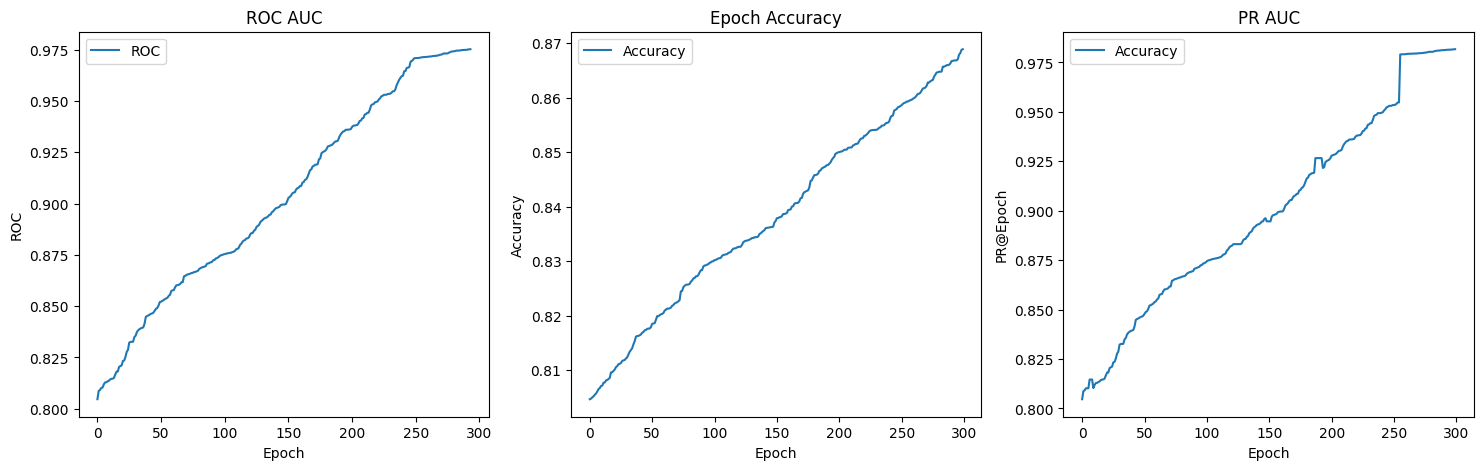

In [7]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history['ROC_AUC'], label='ROC')
plt.title('ROC AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], label='Accuracy')
plt.title('Epoch Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['PR_AUC'], label='Accuracy')
plt.title('PR AUC')
plt.xlabel('Epoch')
plt.ylabel('PR@Epoch')
plt.legend()

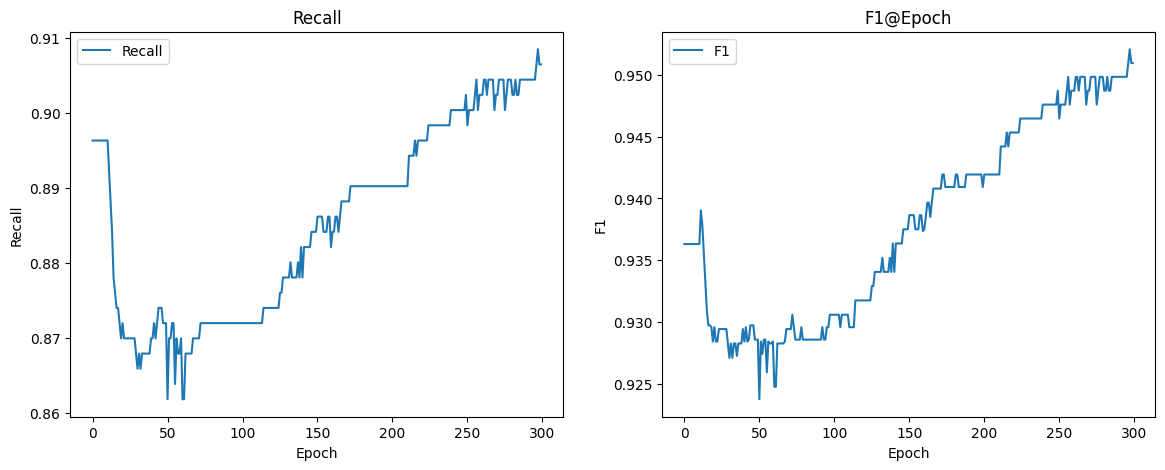

In [22]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history['recall'], label='Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['f1'], label='F1')
plt.title('F1@Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()

# plt.subplot(1, 3, 3)
# plt.plot(history['PR_AUC'], label='Accuracy')
# plt.title('PR AUC')
# plt.xlabel('Epoch')
# plt.ylabel('PR@Epoch')
# plt.legend()